In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
import sigpy as sp
import sigpy.plot as pl
import sigpy.learn
import matplotlib.pyplot as plt
import epgcpmg as epg
import h5py
from tqdm.notebook import tqdm
import cupy as cp
from multiprocessing import Pool
from sklearn.linear_model import OrthogonalMatchingPursuit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_proc = 40
figsize = (8, 2)

<IPython.core.display.Javascript object>


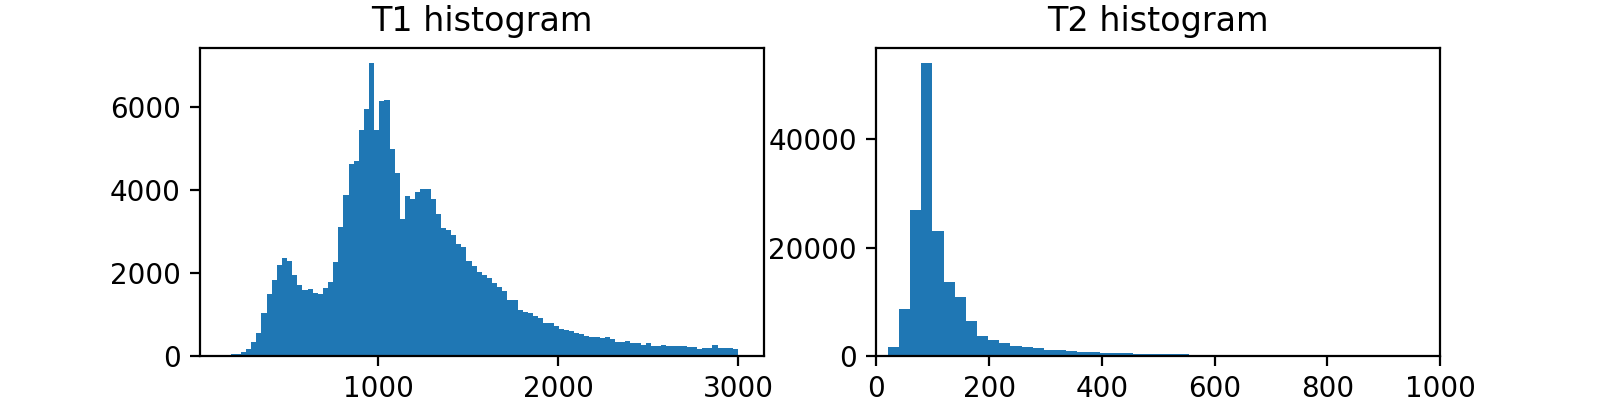

<IPython.core.display.Javascript object>


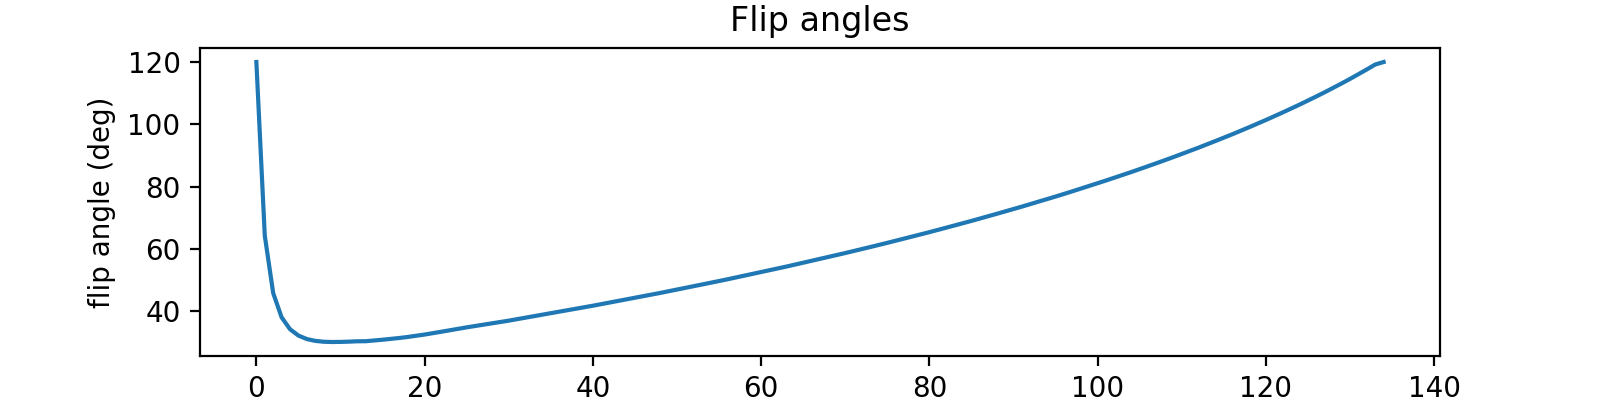

In [3]:
t1_t2_brain = np.load('data/t1t2_brain.npy')
flipangles = np.loadtxt('data/flipangles.txt')
# flipangles = 40*np.random.rand(135)
flipangles_rad = flipangles * np.pi / 180
T = len(flipangles)
N_total = t1_t2_brain.shape[0]

plt.figure(figsize=figsize)
plt.subplot(1,2,1)
plt.hist(t1_t2_brain[:,0], 100)
plt.title('T1 histogram')
plt.xlabel('T1 (ms)')

plt.subplot(1,2,2)
plt.hist(t1_t2_brain[:,1], 100)
plt.title('T2 histogram')
plt.xlabel('T2 (ms)')
plt.xlim([0, 1000])

plt.figure(figsize=figsize)
plt.plot(flipangles)
plt.title('Flip angles')
plt.xlabel('TE number')
plt.ylabel('flip angle (deg)');

In [5]:
N = 1000
TR = 2500
TE = 4.936
e2s = 4

_ridx = np.random.permutation(N_total)
t1_t2_vals = t1_t2_brain[_ridx[:N], :]



def _gen_signal(t1_t2):
    t1, t2 = t1_t2
#     return epg.FSE_signal2_inv_ex(np.pi, flipangles_rad[0], flipangles_rad, 150, TE, t1, t2)[0].squeeze()
    return epg.FSE_signal(flipangles_rad, TE, t1, t2).squeeze()

with Pool(n_proc) as p:
    sig_mat = list((tqdm(p.imap(_gen_signal, t1_t2_vals), total=N, leave=True)))

sig_mat = np.array(sig_mat)
print(sig_mat.shape)


(1000, 135)


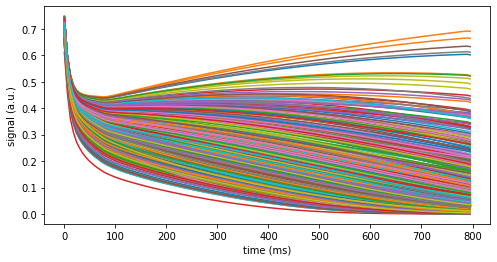

In [6]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot(np.arange(T)*(1+TE), sig_mat.T);
# plt.title('Signal relaxation curves')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

Text(0, 0.5, 'signal (a.u.)')

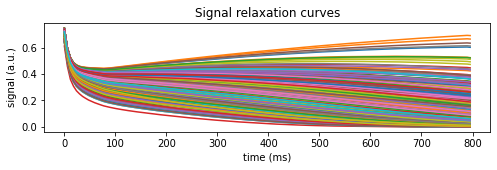

In [7]:
stdev = .0001
sig_n_mat = sig_mat + stdev * np.random.randn(*sig_mat.shape)

plt.figure(figsize=figsize)
plt.plot(np.arange(T)*(1+TE), sig_n_mat.T);
plt.title('Signal relaxation curves')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)')

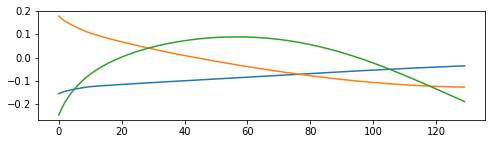

In [8]:
K = 3
u, s, v = np.linalg.svd(sig_mat[:,e2s:-1], full_matrices=False)
phi = v[:K,:]
plt.figure(figsize=figsize)
plt.plot(phi.T);


# import cfl
# cfl.writecfl('data/basis', phi.T)

(130, 1000)
Subspace error: 0.004213367627656772


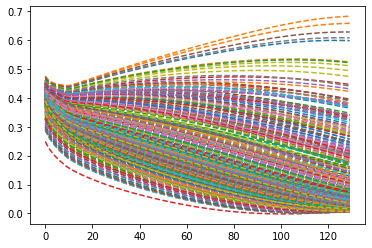

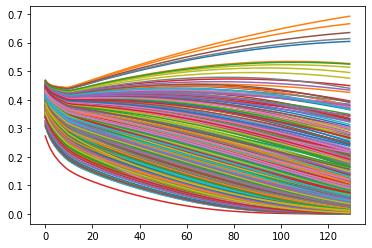

In [9]:
y = sig_mat[:,e2s:-1].T
y_n = sig_n_mat[:,e2s:-1].T
yhat_basis = np.conj(phi).T.dot(phi.dot(y))

plt.figure()
print(yhat_basis.shape)
print('Subspace error:', np.linalg.norm(y.ravel() - yhat_basis.ravel()) / np.linalg.norm(y.ravel()))
plt.plot(yhat_basis, '--');

plt.figure()
plt.plot(y);


In [10]:
def omp_single(yi, L, num_nonzero_coeffs=3, use_sigpy=False, device=None):
    if device is None:
        xp = np
    else:
        xp = sp.Device(device).xp
    resid = yi
    idxs = []
    for k in range(num_nonzero_coeffs):
        z = abs(xp.conj(L.T).dot(resid))
        ii = int(xp.argmax(z))
        idxs = idxs + [ii]
        Lsub = L[:, idxs]
        if use_sigpy:
            A_L = sp.linop.MatMul([len(idxs),1], Lsub)
            vals = sp.app.LinearLeastSquares(A_L, yi, show_pbar=False).run().ravel()
        else:
            if device is None or device == sp.cpu_device:
                rcond = None
            else:
                rcond = -1
            vals = xp.linalg.lstsq(Lsub, yi, rcond=rcond)[0]
        resid = yi - Lsub.dot(vals)
    return idxs, vals.ravel()


class L0Proj(sp.prox.Prox):
    r"""Proximal operator for L0 Proj.

    Args:
        shape (tuple of ints): input shape
        lamda (float): regularization parameter

    """

    def __init__(self, shape, k, axes):
        self.k = k
        self.axes = axes

        super().__init__(shape)


    def top_k(self, input):
        r"""Top k max pooling
        Args:
            input(ndarray): convolutional feature in heigh x width x channel format
            k(int): if k==1, it is equal to normal max pooling
        Returns:
            ndarray: k x (height x width)
        """
        device = sp.backend.get_device(input)
        xp = device.xp

        topk_ind = xp.sort(abs(input).T.argsort()[:,::-1][:,:self.k], axis=1)
        output = xp.zeros(input.shape[::-1], dtype=input.dtype)
        idx = xp.arange(len(topk_ind))
        output[idx, topk_ind.T] = input.T[idx, topk_ind.T]
        return output.T

    def _prox(self, alpha, input):
        with sp.backend.get_device(input):
            return self.top_k(input)
        
class OMP(sp.alg.Alg):
    
    def __init__(
            self,
            y,
            L,
            num_nonzero_coeffs,
            use_sklearn=True,
            n_proc_cpu=1,
            device=sp.cpu_device,
            DC=False,
            **kwargs):
        
        self.use_sklearn = use_sklearn
        
        if self.use_sklearn:
            assert device == sp.cpu_device, 'sklearn not compatible with GPU'
        else:
            self.max_iter = y.shape[1]
            
#         self.max_iter = 1

        self.y = sp.to_device(y, device) # [1000, 135]
        self.L = sp.to_device(L, device)
        self.num_filters = self.L.shape[-1]
        self.num_nonzero_coeffs = num_nonzero_coeffs
        self.device = sp.Device(device)
        self.DC = DC
        self.n_proc_cpu = n_proc_cpu
        
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.R_shape = (self.num_filters, self.num_data)

        xp = self.device.xp
        self.R = xp.zeros((self.num_filters, self.num_data), dtype=self.y.dtype)
        self.iter = 0
                
        super().__init__(self.max_iter)
        
    def _update(self):
        if self.use_sklearn:
            omp = OrthogonalMatchingPursuit(n_nonzero_coefs=self.num_nonzero_coeffs)
            omp.fit(self.L, self.y)
            self.R = omp.coef_.T
        else:
            xp = self.device.xp
            yi = self.y[:, self.iter]
            idxs, vals = omp_single(yi, self.L, self.num_nonzero_coeffs, device=self.device)
            self.R[idxs, self.iter] = vals.ravel()
#             with Pool(self.n_proc_cpu) as p:
#                 self.R = np.array(list((tqdm(p.imap(self._omp_single, self.y.T), total=self.num_data, leave=False)))).T  
    
#     def _omp_single(self, yi):
#         idxs, vals = omp_single(yi, self.L, self.num_nonzero_coeffs)
#         xp = self.device.xp
#         rk = xp.zeros((self.num_filters,), dtype=self.dtype)
#         rk[idxs] = vals.ravel()
#         return rk
        
    def _done(self):
        return (self.iter >= self.max_iter)   
    
class SparseDecom(sp.app.App):
      
    def __init__(
        self,
        y,
        L,
        lamda=0.005,
        mode='l1',
        n_proc_cpu=1,
        DC=False,
        use_sklearn=False,
        device=sp.cpu_device,
        show_pbar=True,
        leave_pbar=True,
        **kwargs):
        self.y = sp.to_device(y, device) # [T, N]
        self.L = sp.to_device(L, device) # [T, K]
        self.lamda = lamda
        self.device = device
        self.mode = mode
        self.show_pbar = show_pbar
        self.leave_pbar = leave_pbar
        self.n_proc_cpu = n_proc_cpu

        self._get_params()
        
        if self.mode is 'omp':
            self.alg = OMP(self.y, 
                           self.L, 
                           self.lamda, 
                           use_sklearn=use_sklearn, 
                           DC=DC,
                           n_proc_cpu=self.n_proc_cpu,
                           device=self.device)
            self._output = self.__output

        else:
            self.A_R = sp.linop.MatMul(
                self.R_shape,
                self.L)
            
            if self.mode is 'l1':
                proxg_R = sp.prox.L1Reg(self.R_shape, lamda)
            elif self.mode is 'l0':
                proxg_R = L0Proj(self.R_shape, lamda, 0)

            self.alg = sp.app.LinearLeastSquares(self.A_R, self.y, proxg=proxg_R, show_pbar=self.show_pbar, **kwargs).alg
         
        super().__init__(self.alg, show_pbar=self.show_pbar, leave_pbar=self.leave_pbar)
        self._output = self.__output



    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_data = self.y.shape[-1]
        self.num_filters = self.L.shape[-1]
        self.num_points = self.L.shape[0]

        self.R_shape = (self.num_filters, self.num_data)
        
    def __output(self):
        if self.mode == 'omp':
            return self.alg.R
        else:
            return self.alg.x

        
class ShuffledNumbers(object):
    """Produces shuffled numbers between given range.

    Args:
        Arguements to numpy.arange.

    """
    def __init__(self, *args):
        self.numbers = np.arange(*args)
        np.random.shuffle(self.numbers)
        self.i = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        ret = self.numbers[self.i]

        self.i += 1
        if self.i == len(self.numbers):
            np.random.shuffle(self.numbers)
            self.i = 0

        return ret

    
      
class SparseCoding(sp.app.App):
   
    
    def __init__(
            self,
            y,
            num_filters,
            batch_size,
            lamda=0.001,
            alpha=0.5,
            R_mode='omp',
            L_mode='ksvd',
            mask_idx=None,
            use_sklearn=False,
            L_init_mode='random',
            DC=False,
            skip_final_decomp=False,
            max_inner_iter=100,
            max_power_iter=10,
            max_iter=10,
            n_proc_cpu=1,
            device=sp.cpu_device,
            **kwargs):
        self.y = sp.to_device(y, device) # [1000, 135]
        self.num_filters = num_filters
        self.batch_size = batch_size
        self.lamda = lamda
        self.alpha = alpha
        self.R_mode = R_mode
        self.L_mode = L_mode
        self.use_sklearn = use_sklearn
        self.max_inner_iter = max_inner_iter
        self.max_power_iter = max_power_iter
        self.max_iter = max_iter
        self.device = device
        self.L_init_mode = L_init_mode
        self.DC = DC
        self.skip_final_decomp = skip_final_decomp
        self.mask_idx = mask_idx
        self.n_proc_cpu = n_proc_cpu

        self._get_params()
        self._get_vars()
        self._get_alg()

        super().__init__(self.alg, show_pbar=True, **kwargs)


    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.batch_size = min(self.num_data, self.batch_size)
        self.num_batches = self.num_data // self.batch_size
        
        self.L_shape = (self.num_points, self.num_filters)
        self.R_t_shape = (self.num_filters, self.batch_size)
           
    def _get_vars(self):
        self.t_idx = ShuffledNumbers(self.num_batches)
        xp = self.device.xp
        with self.device:
            self.y_t = xp.empty((self.num_points, self.batch_size),
                                dtype=self.dtype)
            
            if self.L_init_mode == 'random':
                self.L = sp.randn(self.L_shape, dtype=self.dtype,
                  device=self.device)
            elif self.L_init_mode == 'svd':
                uu, ss, vv = xp.linalg.svd(self.y, full_matrices=False)
                self.L = vv[:, :self.num_filters]
            elif self.L_init_mode == 'data':
                ridx = np.random.permutation(self.num_data)
                self.L = self.y[:, ridx[:self.num_filters]]
            else:
                self.L = sp.to_device(self.L_init_mode, self.device)
                
            if self.DC:
                self.L -= xp.mean(self.L, axis=0, keepdims=True)
                self.L[:, 0] = 1

            self.L /= xp.sum(xp.abs(self.L)**2,
                             axis=(0),
                             keepdims=True)**0.5
            
            self.L_old = xp.empty(self.L_shape, dtype=self.dtype)

            self.R = xp.zeros((self.num_filters, self.num_data), dtype=self.dtype)
            self.R_t = xp.zeros((self.num_filters, self.batch_size), dtype=self.dtype)
            self.current_resid = -1
    def _get_alg(self):
        
        def min_R_t():
            self.R_t = SparseDecom(
                self.y_t,
                self.L,
                lamda=self.lamda,
                mode=self.R_mode,
                use_sklearn=self.use_sklearn,
                DC=self.DC,
                max_power_iter=self.max_power_iter,
                max_iter=self.max_inner_iter,
                device=self.device,
                n_proc_cpu=self.n_proc_cpu,
                show_pbar=False).run()

        def min_L_lls():
            assert not self.DC, 'not implemented'

            self.A_L = sp.linop.RightMatMul(
                self.L_shape,
                self.R_t)

            mu = (1 - self.alpha) / self.alpha

            proxg_L = sp.prox.L2Proj(
                self.L.shape, 1, axes=[0])

            sp.app.LinearLeastSquares(self.A_L, self.y_t, x=self.L,
                                      z=self.L_old,
                                      proxg=proxg_L,
                                      lamda=mu,
                                      max_power_iter=self.max_power_iter,
                                      max_iter=self.max_inner_iter, show_pbar=False).run()
               
        def min_L_ksvd():
            if self.L_mode == 'ksvd':
                approx = False
            else:
                approx = True
            for k in np.random.permutation(self.num_filters):
                if k > 0 or (not self.DC):
                    self.update_filter(k, approx=approx)
                
        if self.L_mode == 'lls':
            min_L = min_L_lls
        else:
            min_L = min_L_ksvd
            
        self.alg = sp.alg.AltMin(min_R_t, min_L, max_iter=self.max_iter)

    def update_filter(self, k, approx=False):
        xp = self.device.xp
        lk = self.L[:, k][:,None]
        rk = self.R_t[k, :][None,:]
        idx = rk.ravel() != 0
        if np.sum(idx) > 0:
#             print(rk)
            if approx:
                self.L[:, k] = 0
                g = rk[:, idx].T
                yI = self.y_t[:, idx]
                RI = self.R_t[:, idx]
                d = yI.dot(g) - self.L.dot(RI).dot(g)
                d /= xp.linalg.norm(d)
                g = yI.T.dot(d) - xp.conj(self.L.dot(RI)).T.dot(d)
                self.L[:, k] = d.ravel()
                self.R_t[k, idx] = g.T
            else:
                Ek = self.y_t - self.L.dot(self.R_t) + lk.dot(rk)
                EkR = Ek[:, idx]
                uu, ss, vv = xp.linalg.svd(EkR, full_matrices=False)
                self.L[:, k] = uu[:,0]
                self.R_t[k, idx] = vv[0,:] * ss[0]          
    
    def _pre_update(self):
        t = self.t_idx.next()
        t_start = t * self.batch_size
        t_end = (t + 1) * self.batch_size

        sp.copyto(self.y_t, self.y[:,t_start:t_end])
        sp.copyto(self.L_old, self.L)
    
    def _summarize(self):
        if self.show_pbar:
            xp = self.device.xp
            self.current_resid = sp.to_device(xp.linalg.norm(self.y_t - self.L.dot(self.R_t)), sp.cpu_device)
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.current_resid))

    def _output(self):  
        if not self.skip_final_decomp:
            self.R = SparseDecom(
                self.y,
                self.L,
                lamda=self.lamda,
                mode=self.R_mode,
                use_sklearn=self.use_sklearn,
                max_power_iter=self.max_power_iter,
                max_iter=self.max_inner_iter,
                device=self.device,
                show_pbar=True,
                leave_pbar=False).run()
        return self.L, self.R



(130, 1000)
17.23079115878442


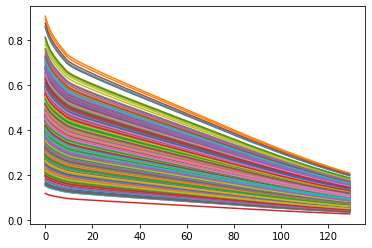

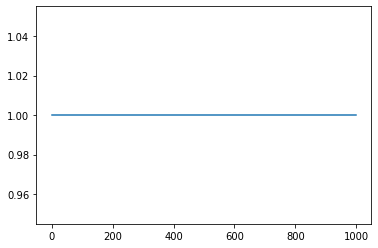

In [11]:
y = sig_mat[:,e2s:-1].T
L = phi.T
# device = sp.Device(3)
device = sp.cpu_device
with device:
    app = SparseDecom(y, L, L.shape[1]-2, n_proc_cpu=20, mode='omp', use_sklearn=False, max_iter=100, max_power_iter=20, device=device)
    x = app.run()
R = sp.to_device(x, sp.cpu_device)
plt.figure()
yhat = L.dot(R)
print(yhat.shape)
print(np.linalg.norm(y.ravel() - yhat.ravel()))
plt.plot(yhat);


plt.figure()
plt.plot(np.sum(R!=0,0));


(130, 20) (20, 1000)


<IPython.core.display.Javascript object>


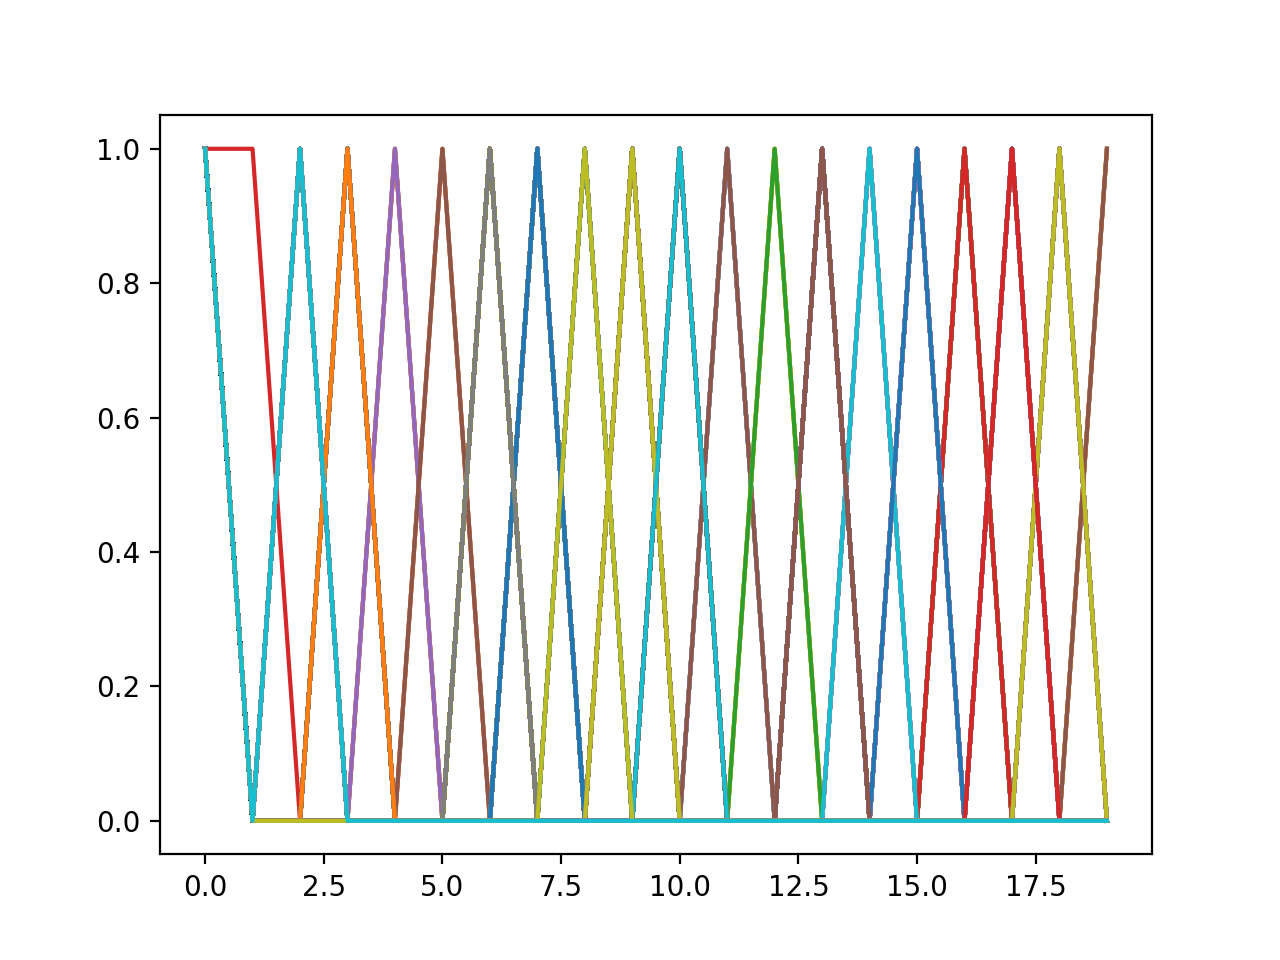

<IPython.core.display.Javascript object>


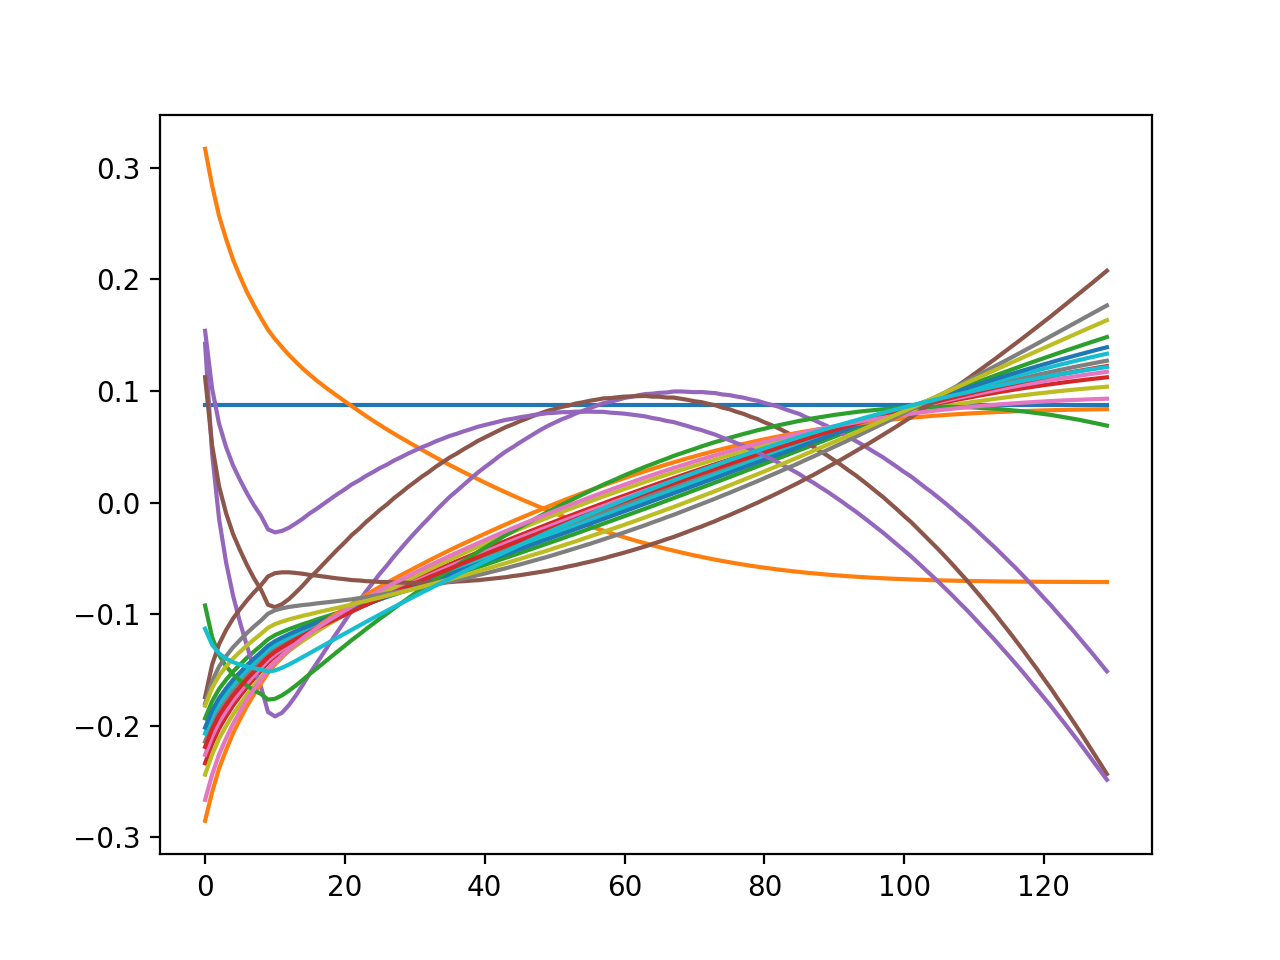

<IPython.core.display.Javascript object>


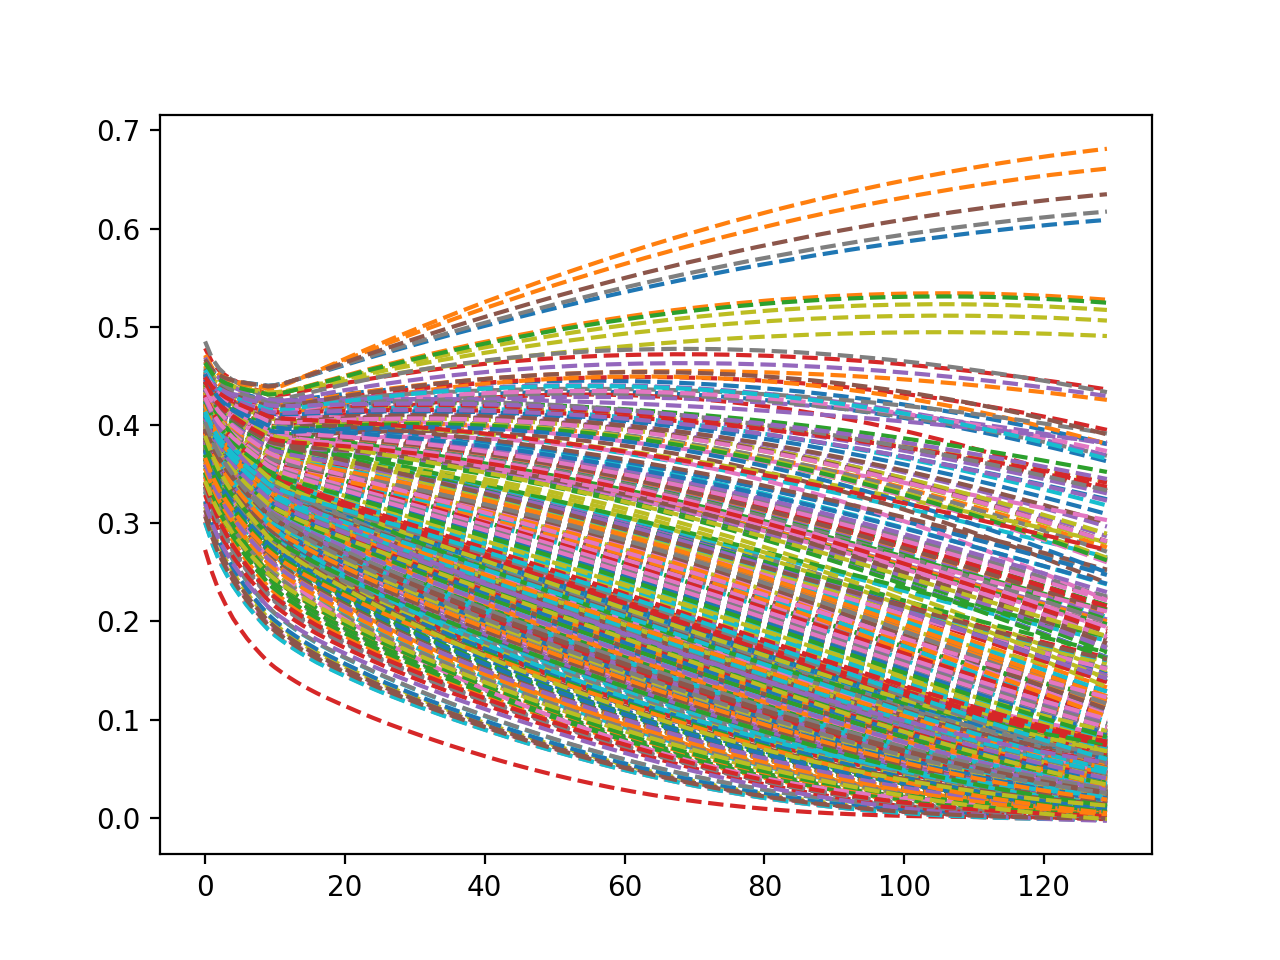

(130, 1000)
Dictionary error: 0.006218750572539295


<IPython.core.display.Javascript object>


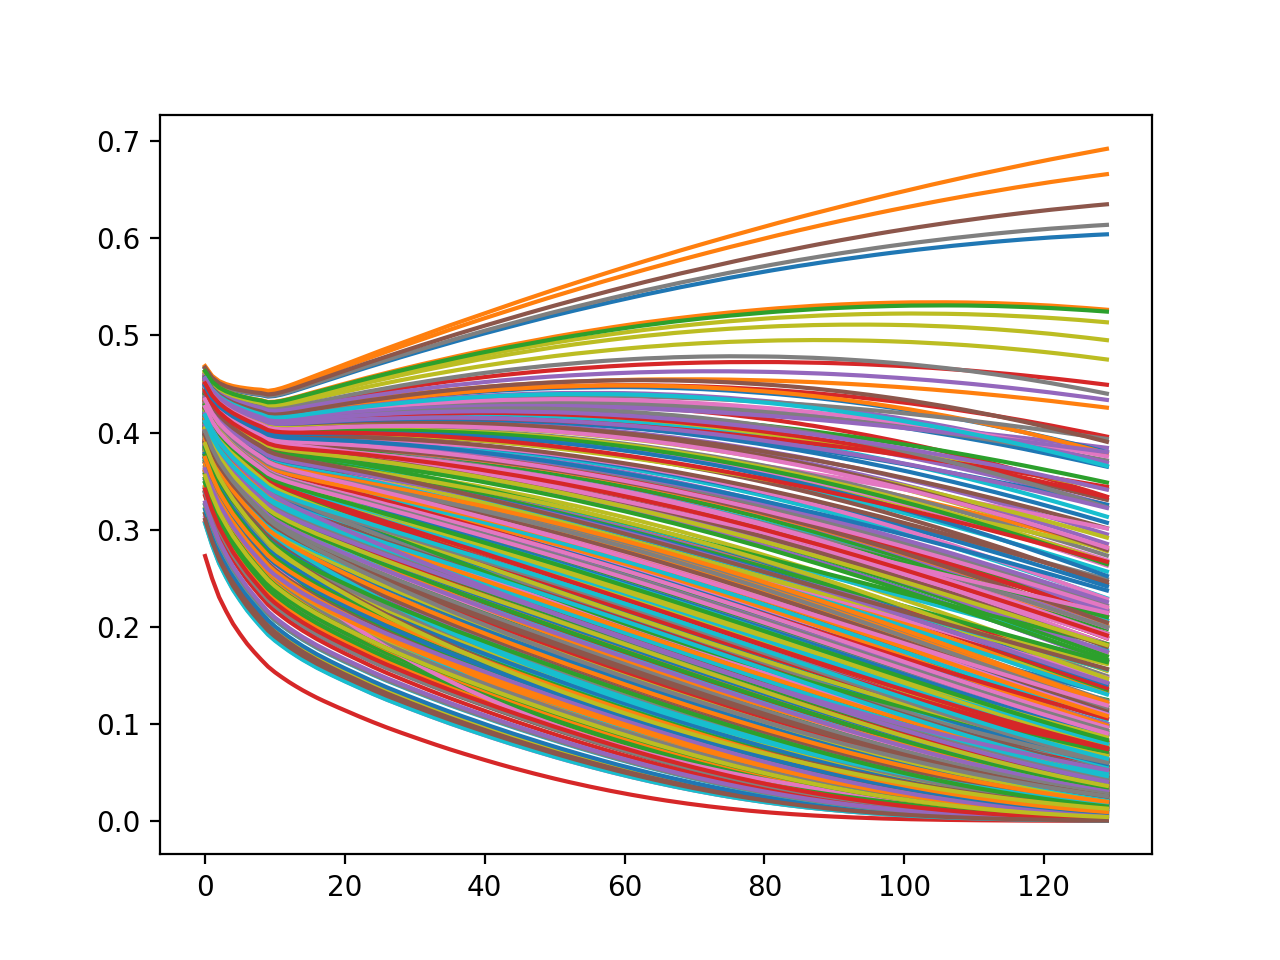

In [23]:
# device = sp.Device(3)
device = sp.cpu_device
num_filters = 20
num_nonzero_coeffs = 2
y = sig_mat[:,e2s:-1].T
n_proc_cpu = 1

with device:
    app = SparseCoding(y, num_filters,
                       L_init_mode='data', 
                       batch_size=100,
                       R_mode='omp',
                       use_sklearn=False, 
                       L_mode='ksvd',
                       lamda=num_nonzero_coeffs, 
                       DC=True,
                       alpha=0.5,
                       max_inner_iter=10,
                       max_iter=200,
                       max_power_iter=30,
                       n_proc_cpu=n_proc_cpu,
                      leave_pbar=True)
    x = app.run()

Lhat, Rhat = x[0], x[1]
print(Lhat.shape, Rhat.shape)

plt.figure()
plt.plot(Rhat != 0);

plt.figure()
plt.plot(Lhat)

plt.figure()
yhat = sp.linop.MatMul(Rhat.shape, Lhat) * Rhat
print(yhat.shape)
print('Dictionary error:', np.linalg.norm(y.ravel() - yhat.ravel()) / np.linalg.norm(y.ravel()))

plt.plot(yhat, '--');

plt.figure()
plt.plot(y);


# cfl.writecfl('data/D', Lhat)

(3, 320, 320)


<IPython.core.display.Javascript object>


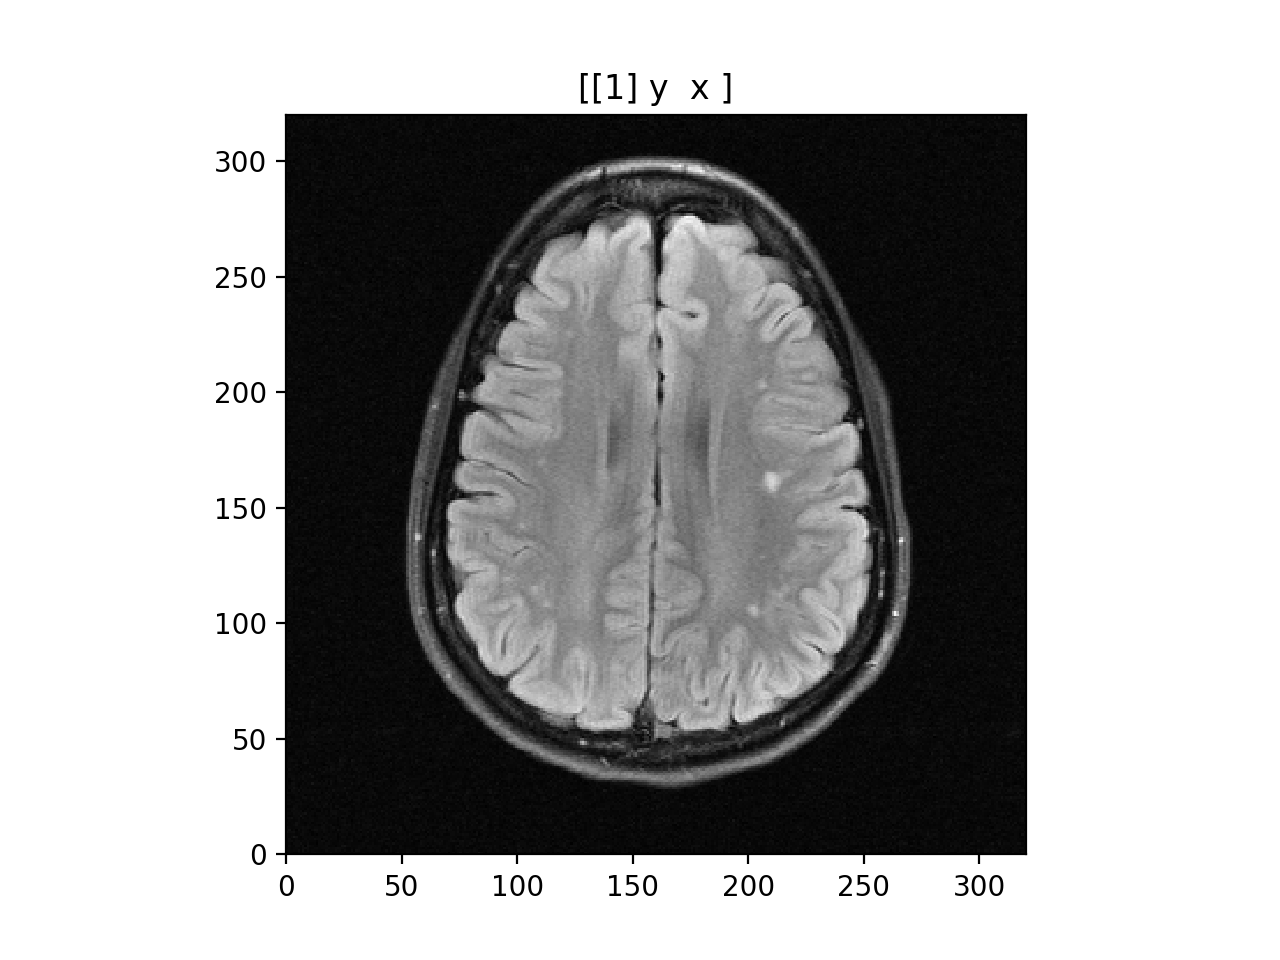

In [33]:
# cfimg = cfl.readcfl('data/cfimg-091').squeeze()
# img = cfimg[...,0]
use_fastmri = True

if use_fastmri:
    idx_slice = [4, 5, 6]
    num_files = 1
    
#     num_files = 1
#     idx_slice = [4]
    files = ['file_brain_AXFLAIR_200_6002462.h5',
             'file_brain_AXFLAIR_200_6002483.h5',
             'file_brain_AXFLAIR_200_6002556.h5',
             'file_brain_AXFLAIR_200_6002572.h5',
             'file_brain_AXFLAIR_200_6002584.h5',
             'file_brain_AXFLAIR_200_6002605.h5',
             'file_brain_AXFLAIR_200_6002471.h5',
             'file_brain_AXFLAIR_200_6002499.h5',
             'file_brain_AXFLAIR_200_6002560.h5',
             'file_brain_AXFLAIR_200_6002574.h5',
             'file_brain_AXFLAIR_200_6002588.h5',
             'file_brain_AXFLAIR_200_6002634.h5',
             'file_brain_AXFLAIR_200_6002477.h5',
             'file_brain_AXFLAIR_200_6002536.h5',
             'file_brain_AXFLAIR_200_6002562.h5',
             'file_brain_AXFLAIR_200_6002581.h5',
             'file_brain_AXFLAIR_200_6002603.h5',
             'file_brain_AXFLAIR_200_6002652.h5']
    num_files = min(num_files, len(files))
    files = files[:num_files]
    file = files[0]
    with h5py.File('data/fastmri/{}'.format(file), 'r') as F:
            _img = np.array(F['reconstruction_rss'][idx_slice,...])
#             _ksp = np.array(F['kspace'][idx_slice,...])
    imgs = np.zeros((num_files, *_img.shape))
#     ksp = np.zeros((num_files, *_ksp.shape))
#     print(ksp.shape)

    imgs[0,...] = _img
#     ksp[0,...] = _ksp

    for i, file in enumerate(files[1:]):
        with h5py.File('data/fastmri/{}'.format(file), 'r') as F:
            _img = np.array(F['reconstruction_rss'][idx_slice,...])        
#             _ksp = np.array(F['kspace'][idx_slice,...])        

        imgs[i,...] = _img
#         ksp[i,...] = _ksp
        
    if len(idx_slice) > 1:
        imgs = imgs.reshape((-1, *imgs.shape[2:]))
#         ksp = ksp.reshape((-1, *ksp.shape[2:]))
    
    img = imgs.copy()

    
else:
    with np.load('data/brain.npz') as data:
#     for key in data.keys():
#         print(key)
        img = np.array(data['im'])
        mask = np.array(data['mask_vardens'])
    img = img[::-1,:]
    mask = mask[::-1,:]
print(img.shape)

pl.ImagePlot(img)

In [34]:
if use_fastmri:
    filter_size = [1, 8, 8]
    strides = [1, 2, 2]
else:
    filter_size = [8, 8]
    strides = [2, 2]
   
num_filters = 100
num_nonzero_coeffs = 7

device = sp.cpu_device
# device = sp.Device(1)
img_blocks = sp.array_to_blocks(img, filter_size, strides)
print(img_blocks.shape)
# L = np.random.randn(filter_size[0], filter_size[1], num_filters)

y_img_blocks = img_blocks.reshape((-1, np.prod(filter_size))).T
print(y_img_blocks.shape)
# remove patches with little-to-no signal
_nrms = np.linalg.norm(y_img_blocks, axis=0)
_mean_nrms = np.mean(_nrms)
print(_mean_nrms)
y_img_blocks_pruned = y_img_blocks[:, _nrms > .25 * _mean_nrms]
print(y_img_blocks.shape, y_img_blocks_pruned.shape)
# plt.figure()
# plt.hist(_nrms, 100)
# plt.figure()
# plt.hist(_nrms[_nrms > .5 * _mean_nrms], 100)

with device:
#     app = SparseDecom(img_blocks.reshape((-1, 16*16)).T, L.reshape((16*16, -1)), 1, mode='omp', use_sklearn=False, max_iter=100, max_power_iter=20, device=device)
#     out_flat = app.run()
    app = SparseCoding(y_img_blocks_pruned, 
                       num_filters, 
                       batch_size=500, 
                       R_mode='omp', 
                       use_sklearn=False, 
                       L_mode='ksvd', 
                       L_init_mode='random',
                       DC=True,
                       lamda=num_nonzero_coeffs,
                       alpha=0.5,
                       max_inner_iter=2000,
                       max_iter=200, 
                       max_power_iter=30,
                       skip_final_decomp=True,
                       device=device)
    out = app.run()
    app2 = SparseDecom(y_img_blocks, out[0], num_nonzero_coeffs, 
                      mode='omp', 
                      DC=True,
                      use_sklearn=False, 
                      max_iter=100, 
                      max_power_iter=20, 
                      device=device)
    out2 = app2.run()

(3, 157, 157, 1, 8, 8)
(64, 73947)
0.0005352911670057487
(64, 73947) (64, 67262)


In [ ]:
# if use_fastmri:
#     filter_size = [1, 8, 8]
#     strides = [1, 4, 4]
# else:
#     filter_size = [8, 8]
#     strides = [4, 4]
   
# num_filters = 100
# # num_nonzero_coeffs = 10

# # device = sp.cpu_device
# device = sp.Device(1)
# img_blocks = sp.array_to_blocks(img, filter_size, strides)
# print(img_blocks.shape)
# # L = np.random.randn(filter_size[0], filter_size[1], num_filters)

# y_img_blocks = img_blocks.reshape((-1, np.prod(filter_size))).T
# print(y_img_blocks.shape)
# # remove patches with little-to-no signal
# _nrms = np.linalg.norm(y_img_blocks, axis=0)
# _mean_nrms = np.mean(_nrms)
# print(_mean_nrms)
# y_img_blocks_pruned = y_img_blocks[:, _nrms > .25 * _mean_nrms]
# print(y_img_blocks.shape, y_img_blocks_pruned.shape)
# # plt.figure()
# # plt.hist(_nrms, 100)
# # plt.figure()
# # plt.hist(_nrms[_nrms > .5 * _mean_nrms], 100)

# l1reg = .00001

# with device:
# #     app = SparseDecom(img_blocks.reshape((-1, 16*16)).T, L.reshape((16*16, -1)), 1, mode='omp', use_sklearn=False, max_iter=100, max_power_iter=20, device=device)
# #     out_flat = app.run()
#     app = SparseCoding(y_img_blocks_pruned, 
#                        num_filters, 
#                        batch_size=500, 
#                        R_mode='l1', 
#                        use_sklearn=False, 
#                        L_mode='lls', 
#                        L_init_mode='data',
#                        DC=False,
#                        lamda=l1reg,
#                        alpha=.8,
#                        max_inner_iter=200,
#                        max_iter=500, 
#                        max_power_iter=30,
#                        skip_final_decomp=True,
#                       device=device)
#     out = app.run()
#     app2 = SparseDecom(y_img_blocks, 
#                         out[0],
#                         l1reg, 
#                         mode='l1', 
#                         DC=False,
#                         use_sklearn=False, 
#                         max_iter=200, 
#                         max_power_iter=30, 
#                         device=device)
#     out2 = app2.run()

(1, 8, 8, 100) (100, 3, 157, 157, 1)


<IPython.core.display.Javascript object>


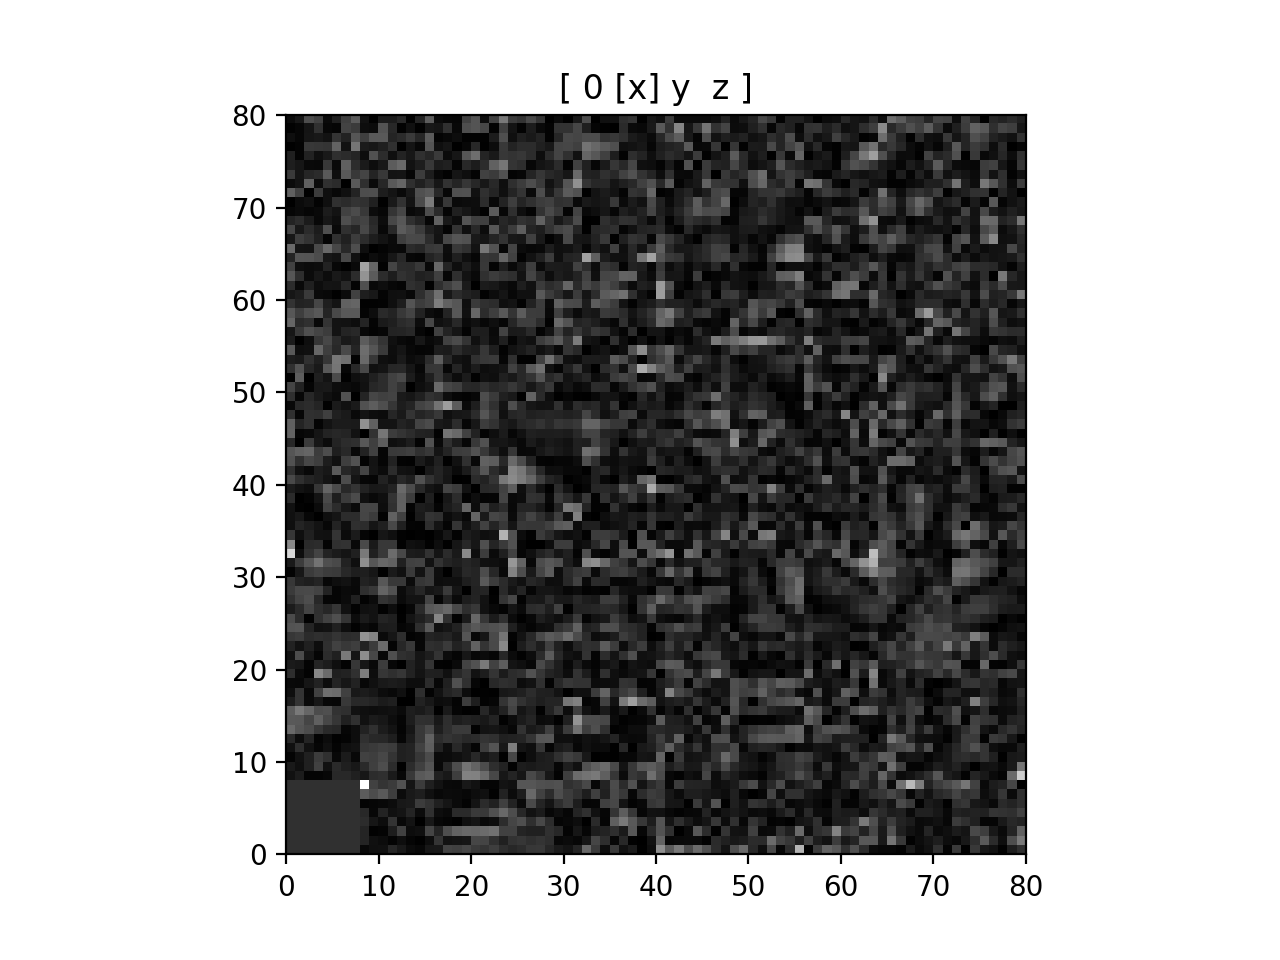

In [35]:
Lhat_flat, Rhat_flat = sp.to_device(out[0], sp.cpu_device), sp.to_device(out2, sp.cpu_device)
Lhat = Lhat_flat.reshape((*filter_size, num_filters))
Rhat = Rhat_flat.reshape((num_filters, *img_blocks.shape[:-2]))

print(Lhat.shape, Rhat.shape)
# out = sp.to_dpevice(out_flat.T.reshape(*img_blocks.shape[:2], -1))


# print(out.shape)
# %matplotlib notebook
# pl.ImagePlot(out, x=0, y=1, z=2)

pl.ImagePlot(Lhat, x=-3, y=-2, z=-1, interpolation='nearest')

<IPython.core.display.Javascript object>


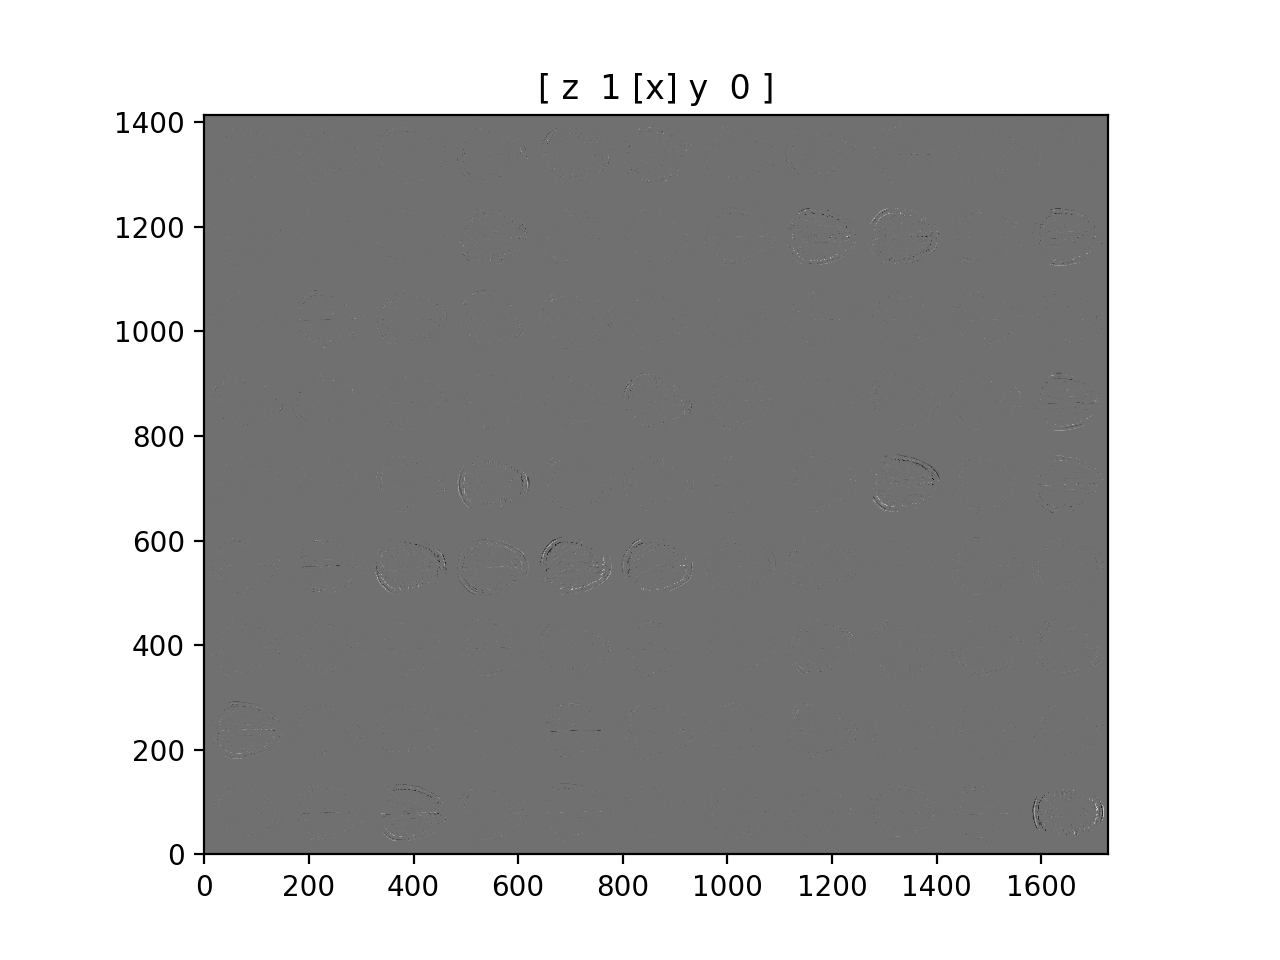

In [36]:
pl.ImagePlot(Rhat[1:,...], z=0, x=-3, y=-2)

(64, 73947)


<IPython.core.display.Javascript object>


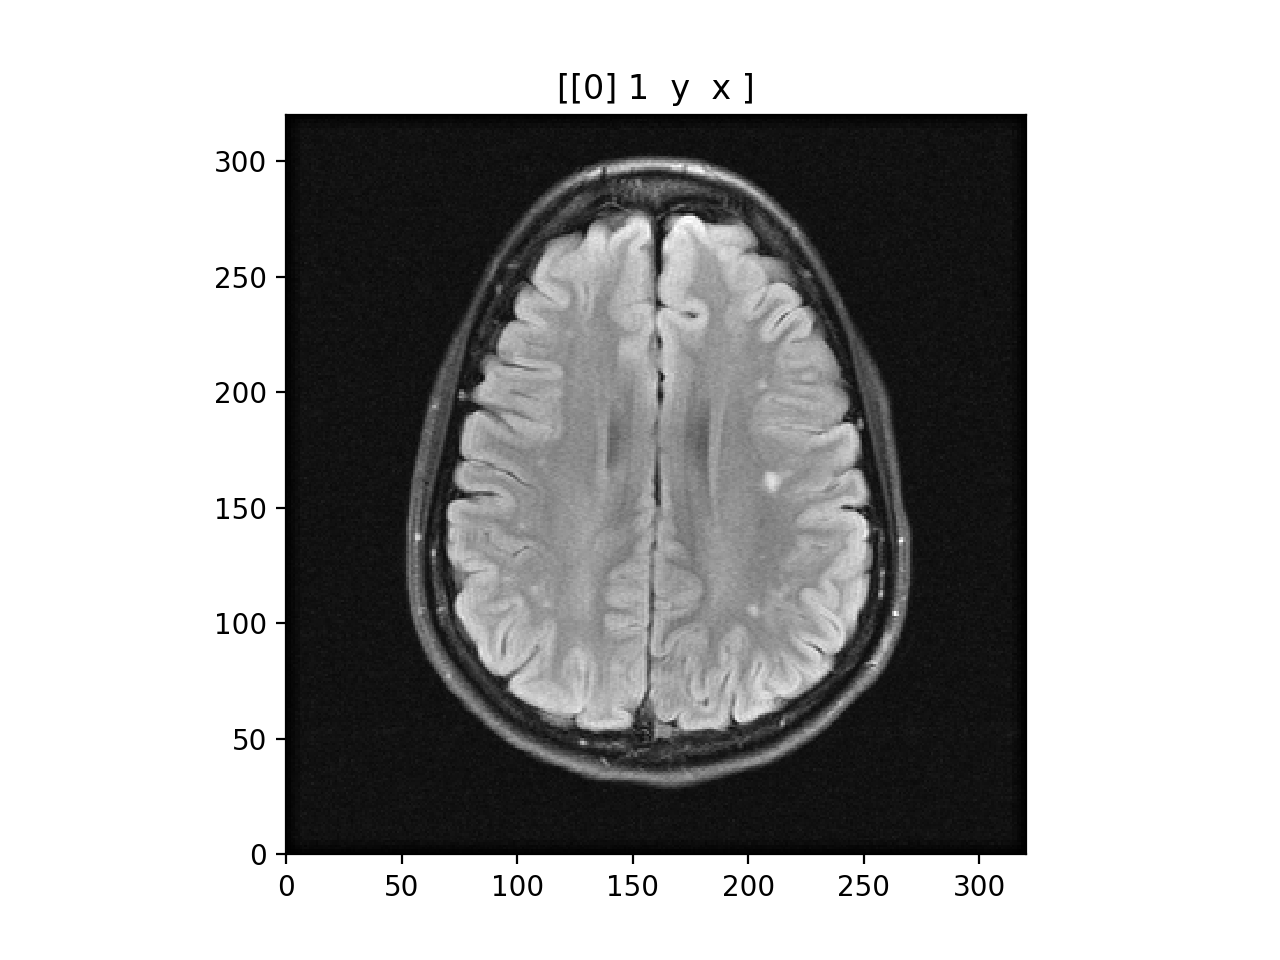

In [37]:
img_hat_flat = Lhat_flat.dot(Rhat_flat)
print(img_hat_flat.shape)
img_hat_blocks = img_hat_flat.T.reshape(img_blocks.shape)
img_hat = sp.blocks_to_array(img_hat_blocks, img.shape, filter_size, strides)
img2 = sp.blocks_to_array(img_blocks, img.shape, filter_size, strides)

pl.ImagePlot(np.stack((img2, img_hat, img2-img_hat)))

In [ ]:
@nb.guvectorize([(nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:])], "(T), (N) -> (T), (N)")        
def nb_update_filter(lk, rk, lk2, rk2):
    T = len(lk)
    N = len(rk)
    for i in range(T):
        lk2[i] = lk[i]
    for i in range(N):
        rk2[i] = rk[i]
#     print(lk.shape, rk.shape)
    idx = rk.ravel() != 0
    if np.sum(idx) > 0:
        Ek = np.outer(lk, rk)
        EkR = Ek[:, idx]
#         uu, ss, vv = np.linalg.svd(EkR, full_matrices=False)
#         for i in range(T):
#             lk2[i] = uu[i,0]
#         rk2[idx] = vv[0,:] * ss[0]
        


In [ ]:
# five filters of length 10 each
# 20 examples
import time
L = np.random.randn(64, 100)
R = np.random.randn(100, 5000)
# print(L)

tic = time.time()
LL, RR = update_filter(L.copy(), R.copy())
toc = time.time()
print('time:', toc - tic)

tic = time.time()
LL2, RR2 = nb_update_filter(L.T, R)
toc = time.time()
print('nbtime:', toc - tic)

print(LL.shape, RR.shape)
print(LL2.shape, RR2.shape)
print(np.linalg.norm(LL2-LL.T), np.linalg.norm(RR2-RR))

In [ ]:
fft_op = sp.linop.FFT(img.shape, axes=(-1,-2))
mask_op = sp.linop.Multiply(fft_op.oshape, mask)
mri_op = mask_op * fft_op

zz = mri_op * img
pl.ImagePlot(zz)

In [ ]:
print(img[14,...].shape)
op = sp.linop.BlocksToArray(img[0,...].shape, [8, 8], [8, 8])
print(op.ishape)


<IPython.core.display.Javascript object>


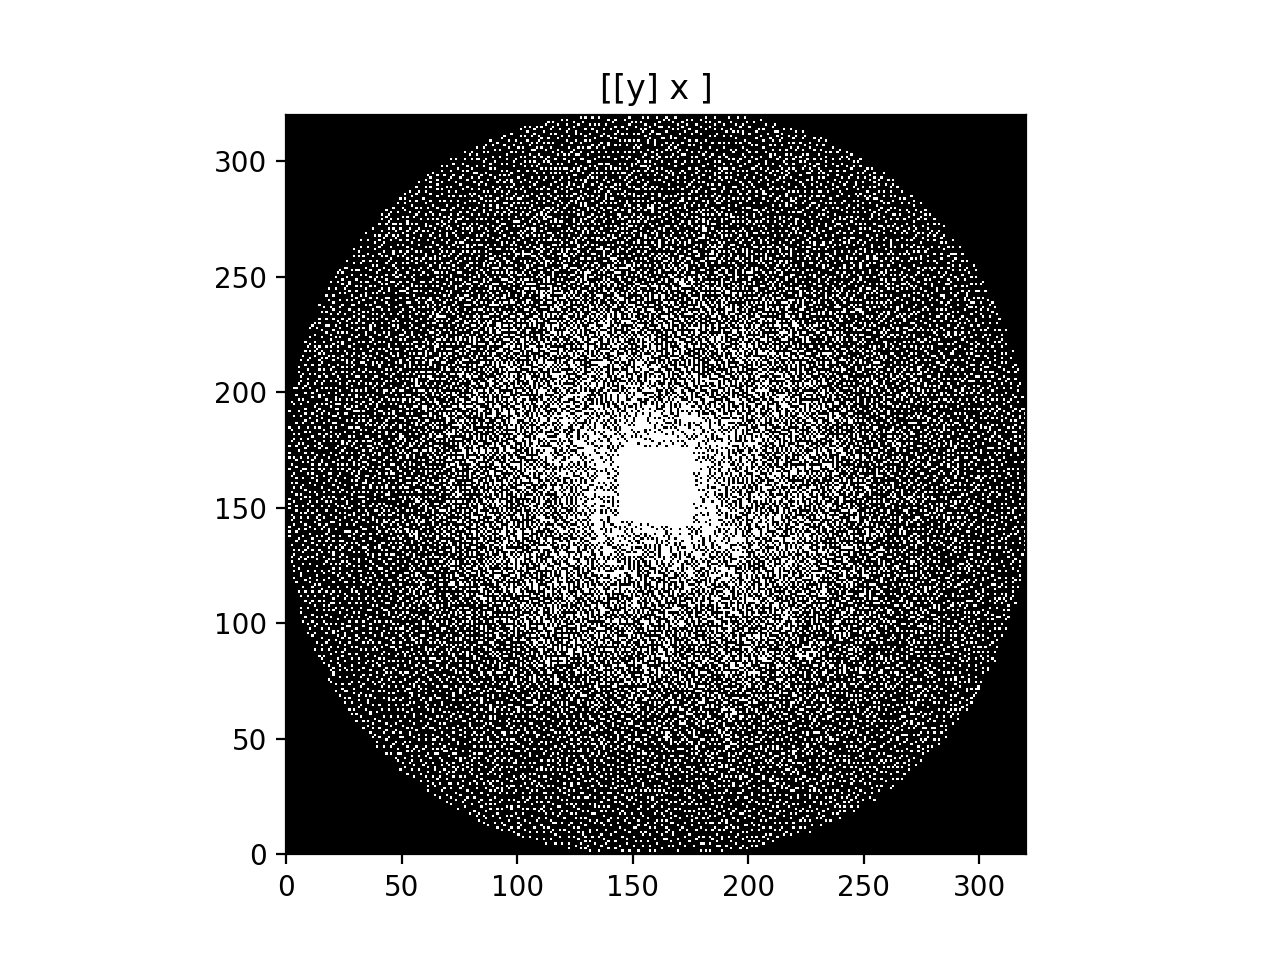

(16, 320, 320)
(320, 320)


<IPython.core.display.Javascript object>


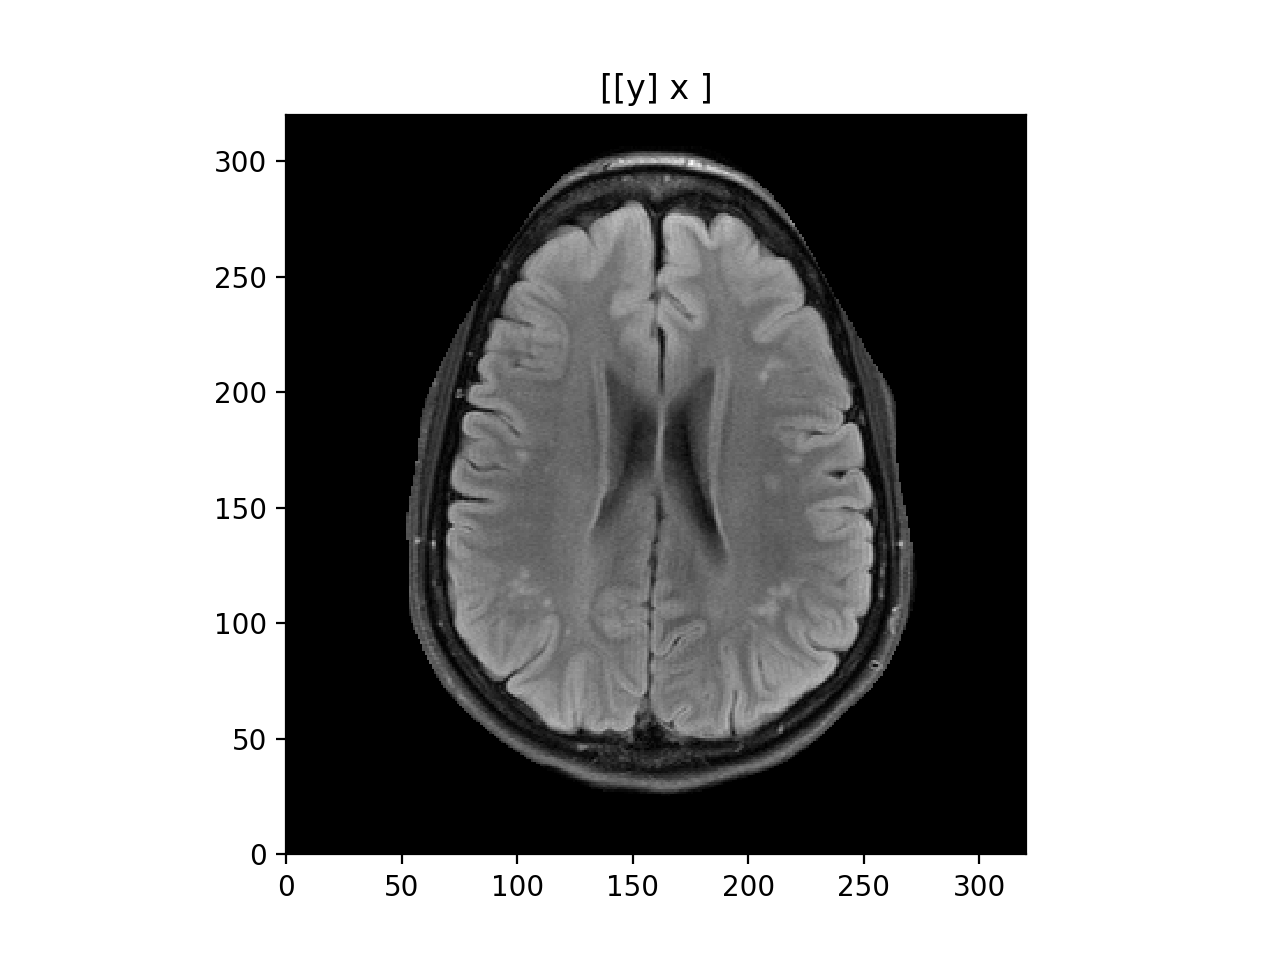

In [38]:
file = files[0]

if use_fastmri:
    with h5py.File('data/fastmri/{}'.format(file), 'r') as F:
#             _img = np.array(F['reconstruction_rss'][idx_slice,...])
            ksp = np.array(F['kspace'][idx_slice[0],...])
            _cimg = sp.ifft(ksp, axes=(-1, -2))
            _cimg2 = sp.resize(_cimg, [ksp.shape[0], ksp.shape[1]//2, ksp.shape[2]])
            ksp = sp.fft(_cimg2, axes=(-1, -2))

            
    from sigpy.mri import poisson
    mask = poisson(ksp.shape[1:], accel=4, calib=[32, 32], dtype=img.dtype)
    pl.ImagePlot(mask)
    
    from bart import bart
    print(ksp.shape)
    maps, evals = bart(2, 'ecalib -m1 -c .99', np.expand_dims(ksp.transpose((1, 2, 0)), 0))
    maps = maps.squeeze().transpose((2, 0, 1))
    
    img = np.sum(np.conj(maps) * _cimg2, 0)
else:
    img = img[:,::-1]
print(img.shape)

pl.ImagePlot(img)

<IPython.core.display.Javascript object>


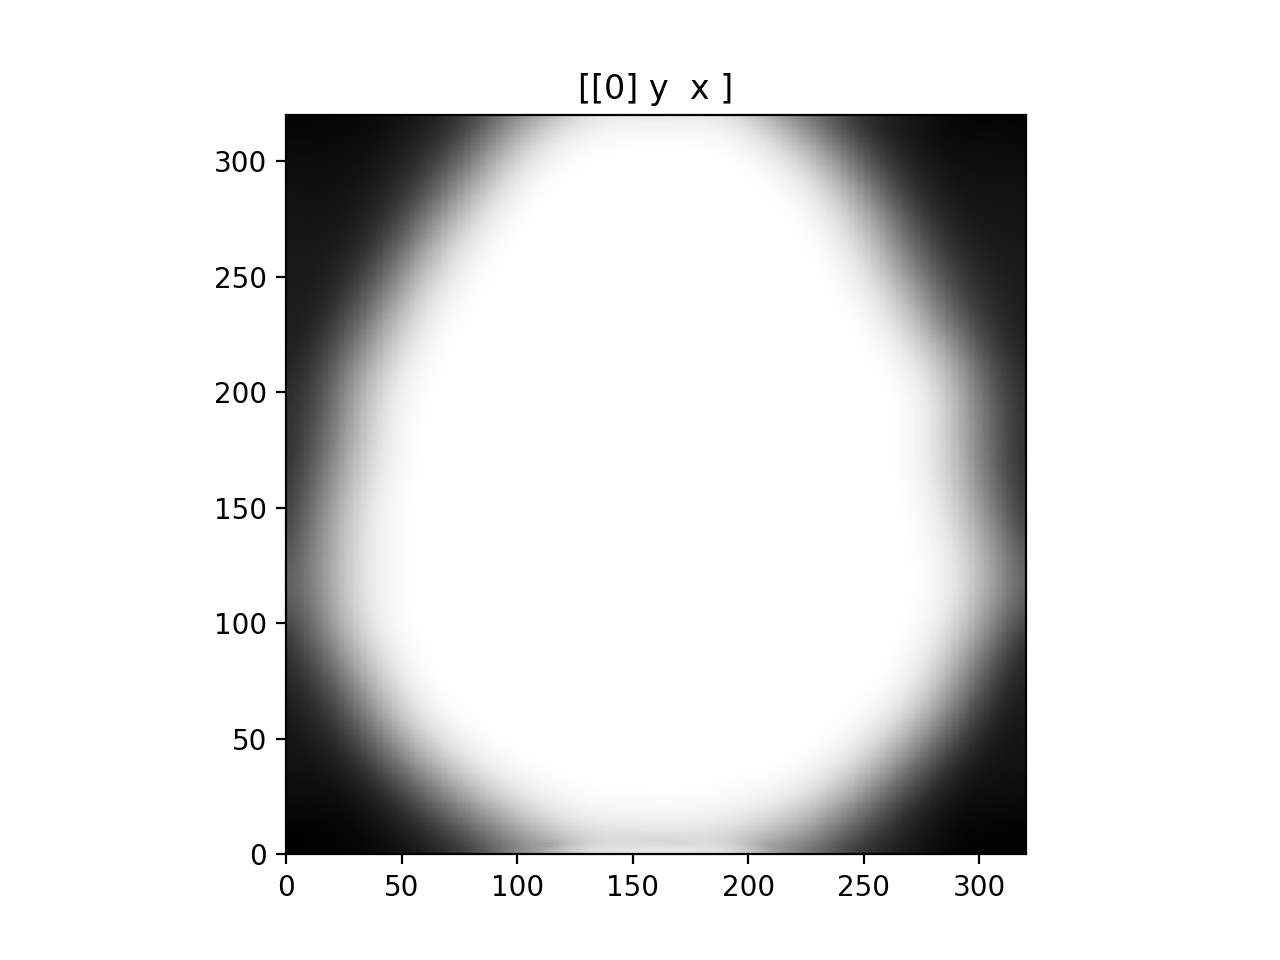

In [39]:
pl.ImagePlot(evals)

(16, 320, 320)


<IPython.core.display.Javascript object>


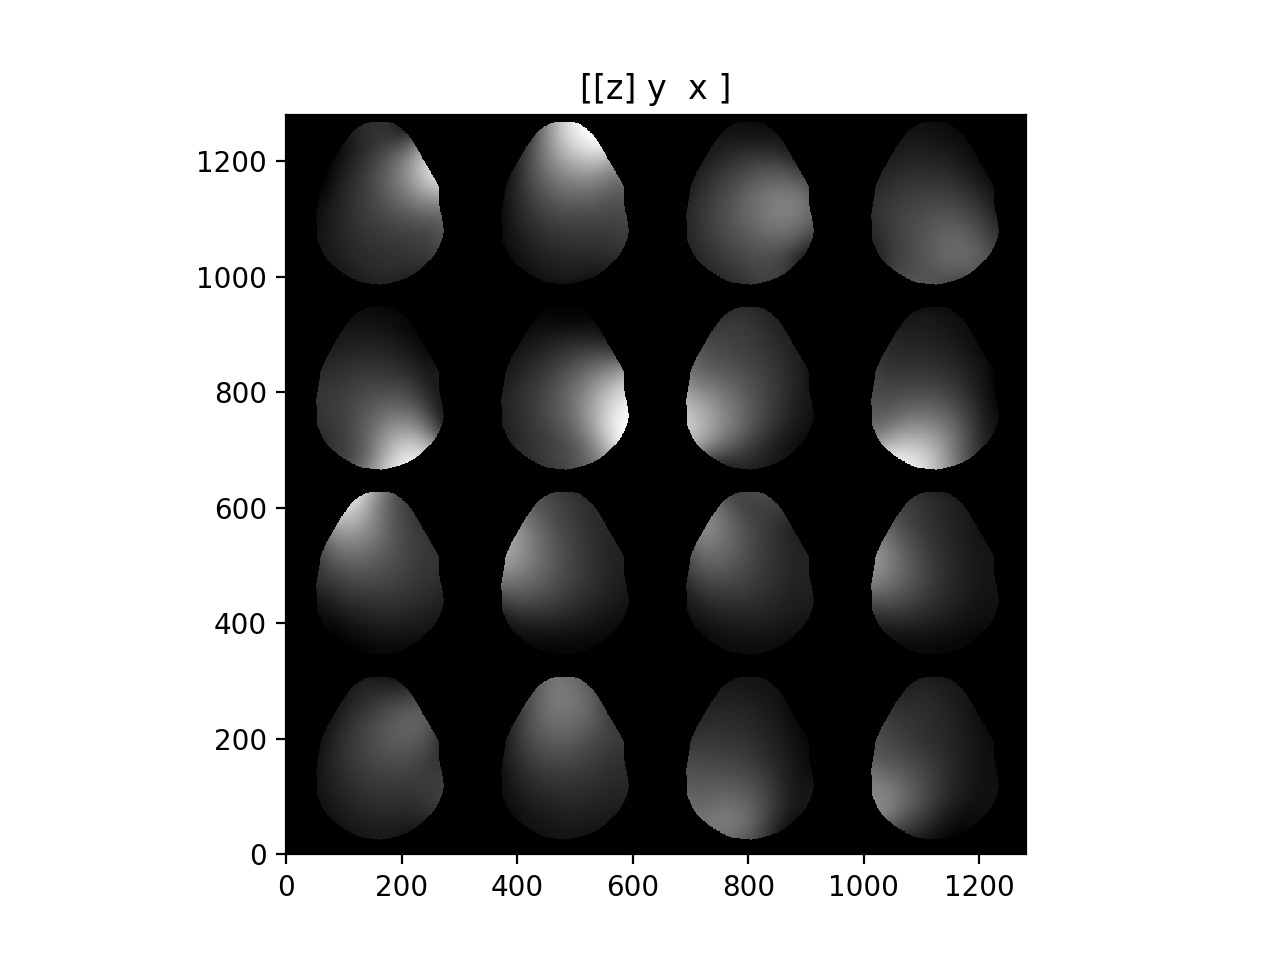

In [40]:
print(maps.shape)
pl.ImagePlot(maps, z=0)

<IPython.core.display.Javascript object>


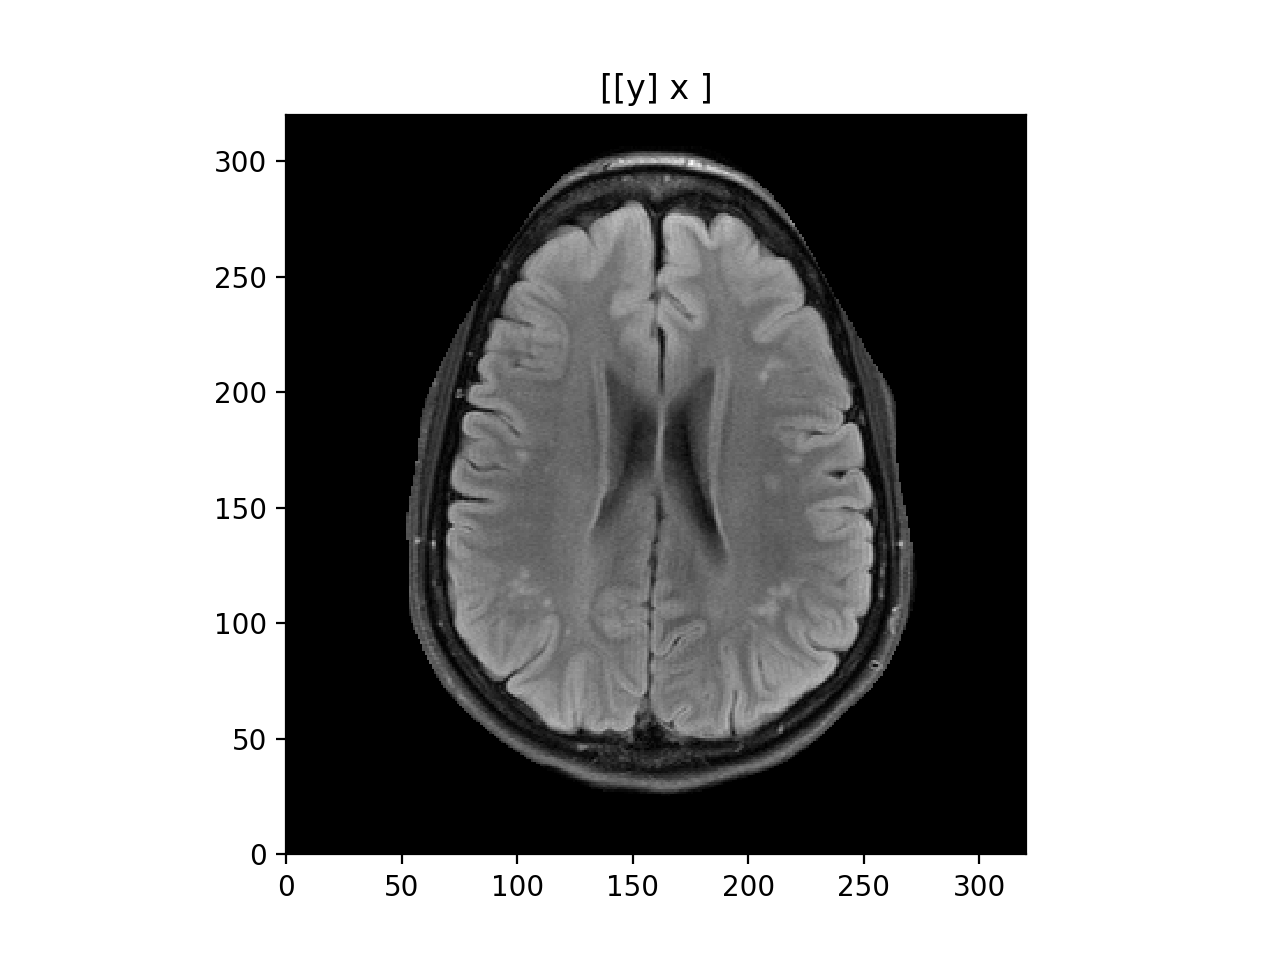

In [41]:
pl.ImagePlot(img)

In [42]:
from sigpy.mri.linop import Sense

class MRISparseCoding(sp.app.App):
   
    def __init__(
            self,
            ksp, # [nc, nx, ny]
            mask, #[nx, ny]
            maps,
            num_filters,
            batch_size,
            block_shape, # [bx, by]
            block_strides, # [sx sy]
            lamda=0.001,
            alpha=0.5,
            nu = .01,
            R_mode='omp',
            L_mode='ksvd',
            use_sklearn=False,
            L_init_mode='random',
            DC=False,
            max_inner_iter=100,
            max_power_iter=10,
            max_iter=10,
            img_ref=None,
            device=sp.cpu_device,
            **kwargs):
        
        
        self.ksp = sp.to_device(ksp, device)
        self.mask = sp.to_device(mask, device)
       
        self.maps = maps
        if self.maps != None:
            self.maps = sp.to_device(maps, device)
        
        if img_ref is None:
            self.img_ref = None
        else:
            self.img_ref = sp.to_device(img_ref, device)

        self.num_filters = num_filters
        self.batch_size = batch_size
        self.block_shape = block_shape
        self.block_strides = block_strides
        self.nu = nu
        self.lamda = lamda
        self.alpha = alpha
        self.R_mode = R_mode
        self.L_mode = L_mode
        self.use_sklearn = use_sklearn
        self.max_inner_iter = max_inner_iter
        self.max_power_iter = max_power_iter
        self.max_iter = max_iter
        self.device = device
        self.L_init_mode = L_init_mode
        self.DC = DC

        self.first = True
        self.residuals = []
        self.nrmse_vals = []

        self._get_params()
        self._get_vars()
        self._get_alg()

        super().__init__(self.alg, **kwargs)
           
        
    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.ksp.dtype
        
        self.ndims = len(self.ksp.shape)
        if self.ndims > 2:
            self.img_shape = self.ksp.shape[-(self.ndims-1):]
        else:
            self.img_shape = self.ksp.shape
            
        if self.maps != None:
            fft_sense_op = Sense(self.maps, ishape=self.img_shape)
        else:
            fft_sense_op = sp.linop.FFT(self.ksp.shape, axes=(-1,-2))
            
        mask_op = sp.linop.Multiply(self.ksp.shape, self.mask)
        self.mri_op = mask_op * fft_sense_op 

        block_op = sp.linop.BlocksToArray(self.img_shape, self.block_shape, self.block_strides)
        
        self.img_blocks_shape = block_op.ishape

        self.num_data = np.prod(self.img_blocks_shape[:2])
        self.num_points = np.prod(self.img_blocks_shape[2:])
        
        print('num_data:', self.num_data)
        print('num_points:', self.num_points)
        
        reshape_op = sp.linop.Reshape(block_op.ishape, (self.num_data, self.num_points))
        
        self.reshape_block_op = block_op * reshape_op

        self.L_shape = (self.num_points, self.num_filters)
        self.R_shape = (self.num_filters, self.num_data)
#         print(self.L_shape, self.R_shape)
        
        self.forward_op = self.mri_op * self.reshape_block_op
#         print(self.forward_op.oshape, self.forward_op.ishape)
        
    def _get_vars(self):
        xp = self.device.xp
        
        with self.device:
            
            self.img_adjoint = self.mri_op.H * self.ksp
            self.img_blocks_flat = (self.forward_op.H * self.ksp).T
            
#             print(self.img_blocks_flat.shape)

            self.R = xp.zeros((self.num_filters, self.num_data), dtype=self.dtype)
            self.L = xp.zeros((self.num_points, self.num_filters), dtype=self.dtype)
            self.block_scale_factor = self.reshape_block_op * self.reshape_block_op.H * xp.ones(self.img_shape, dtype=self.dtype)
            
            if self.img_ref is not None:
                self.img_ref = self.reshape_block_op * self.reshape_block_op.H * self.img_ref
                self.img_ref /= self.block_scale_factor
                    
            img_mask = xp.array(abs(self.img_adjoint) > .1 * max(abs(self.img_adjoint.ravel())), dtype=self.dtype)

            img_mask_blocks = self.reshape_block_op.H * img_mask
#             print('shape:', img_mask_blocks.shape)
            count = xp.sum(img_mask_blocks, axis=-1)
            self.block_idx = count > 1
            
#             print(self.img_blocks_flat.shape, self.block_idx.shape)

    def _get_alg(self):
            
        def min_ksvd():
            if self.first:
                L_init_mode = self.L_init_mode
                self.first = False
            else:
                L_init_mode = self.L
            self.L, _R = SparseCoding(self.img_blocks_flat[:, self.block_idx], 
                                      self.num_filters, 
                                      batch_size=self.batch_size, 
                                      R_mode=self.R_mode,
                                      use_sklearn=self.use_sklearn, 
                                      L_mode=self.L_mode, 
                                      L_init_mode=L_init_mode,
                                      DC=self.DC,
                                      lamda=self.lamda,
                                      mask_idx=self.block_idx,
                                      alpha=0.5,
                                      max_inner_iter=2000,
                                      max_iter=self.max_inner_iter, 
                                      max_power_iter=30,
                                      skip_final_decomp=False,
                                      leave_pbar=False,
                                      device=self.device).run() 
            self.R[:, self.block_idx] = _R
            
            
        def min_mri():
            img = self.L.dot(self.R)
            img = self.reshape_block_op * img.T
            img /= self.block_scale_factor
                        
            app = sp.app.LinearLeastSquares(self.mri_op, 
                                            self.ksp, 
                                            lamda=self.nu, 
                                            z=img,  
                                            max_iter=25, 
                                            save_objective_values=True,
                                            show_pbar=True,
                                            leave_pbar=False)
            self.img_out = app.run()
            self.objective_values = app.objective_values
            self.img_blocks_flat = (self.reshape_block_op.H * self.img_out).T
            
        self.alg = sp.alg.AltMin(min_ksvd, min_mri, max_iter=self.max_iter)
#             self._x = 
#             A_fun = lambda x: x
#             B_fun = lambda z: -z
#             self.alg = sp.alg.ADMM(min_mri, min_ksvd, self._x, self._z, self._u, A_fun, B_fun, c)
    
    def _summarize(self):
        if self.show_pbar:
            xp = self.device.xp
            self.residuals.append(self.objective_values[-1])
            if self.img_ref is None:
                val = self.residuals[-1]
                self.pbar.set_postfix(resid='{0:.2E}'.format(val))
            else:
                val = xp.linalg.norm(self.img_ref - self.img_out) / xp.linalg.norm(self.img_ref)
                self.nrmse_vals.append(val)

                self.pbar.set_postfix(nrmse='{0:.2E}'.format(val))

    def _output(self):  
        return self.L, self.R, self.img_out

<IPython.core.display.Javascript object>


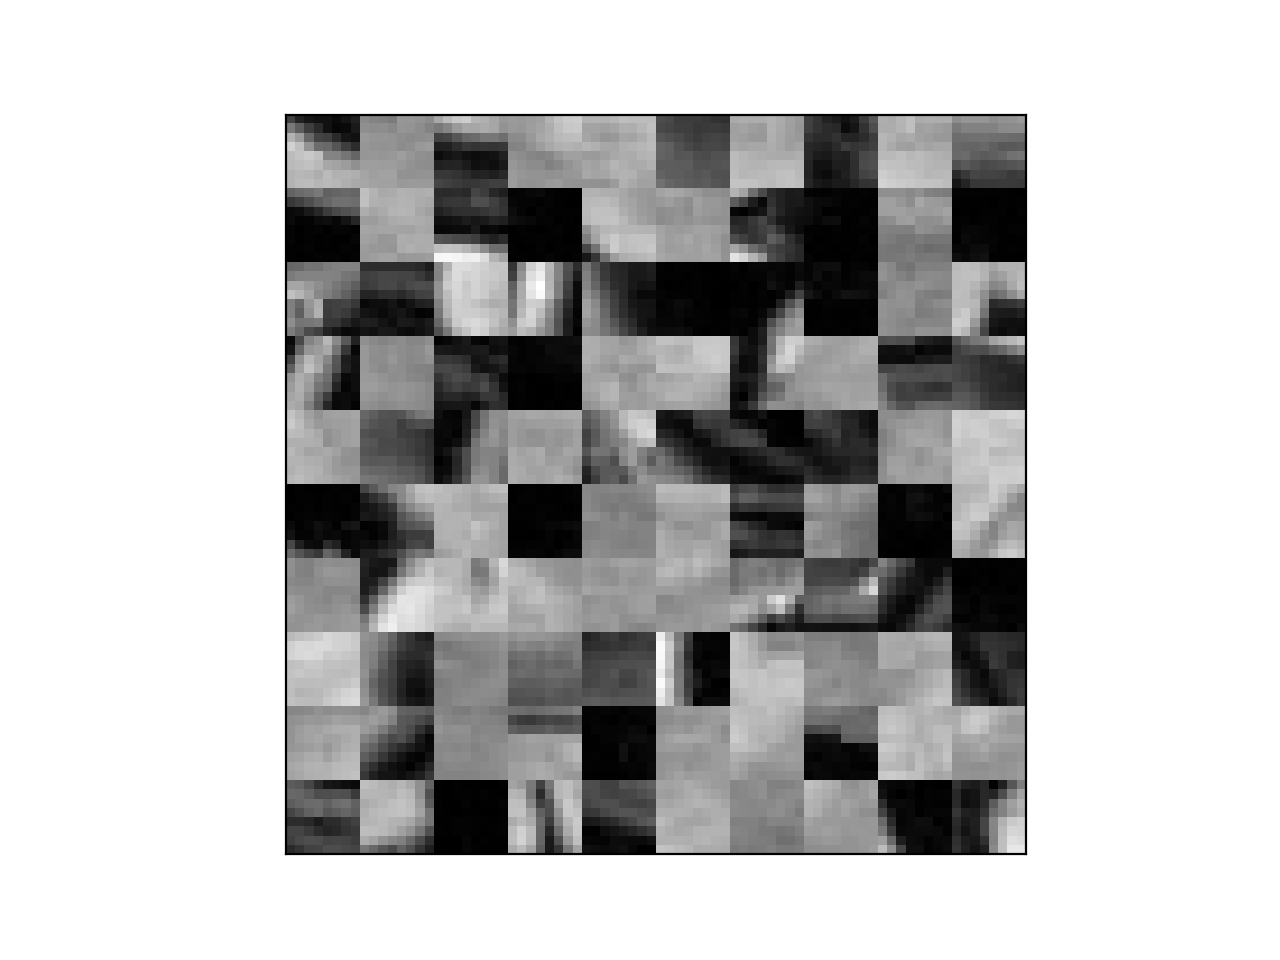

In [69]:
zz = np.reshape(app.img_blocks_flat[:, app.block_idx], (8, 8, -1))
__idx = np.random.permutation(zz.shape[-1])
pl.ImagePlot(zz[...,__idx[:100]], x=0,y=1,z=2)

In [51]:
num_filters = 100
batch_size = 500
block_shape = [8, 8]
block_strides = [4, 4]
num_nonzero_coeffs = 15
max_iter = 25

use_multichannel = False

if use_multichannel:
    _ksp = ksp
    _maps = maps
else:
    _ksp = mask * sp.fft(img, axes=(-1, -2))
    _maps = None



device = sp.cpu_device
# device = sp.Device(3)

with device:
    app = MRISparseCoding(_ksp,
                          mask,
                          _maps,  
                          num_filters,
                          batch_size,
                          block_shape,
                          block_strides,
                          num_nonzero_coeffs,
                          nu=.05,
                          R_mode = 'omp',
                          L_mode = 'ksvd',
                          use_sklearn=False,
                          L_init_mode='data',
                          DC=True,
                          max_inner_iter=20,
                          max_iter=max_iter,
                          img_ref=img,
                          device=device)
    out = app.run()

num_data: 6241
num_points: 64


<IPython.core.display.Javascript object>


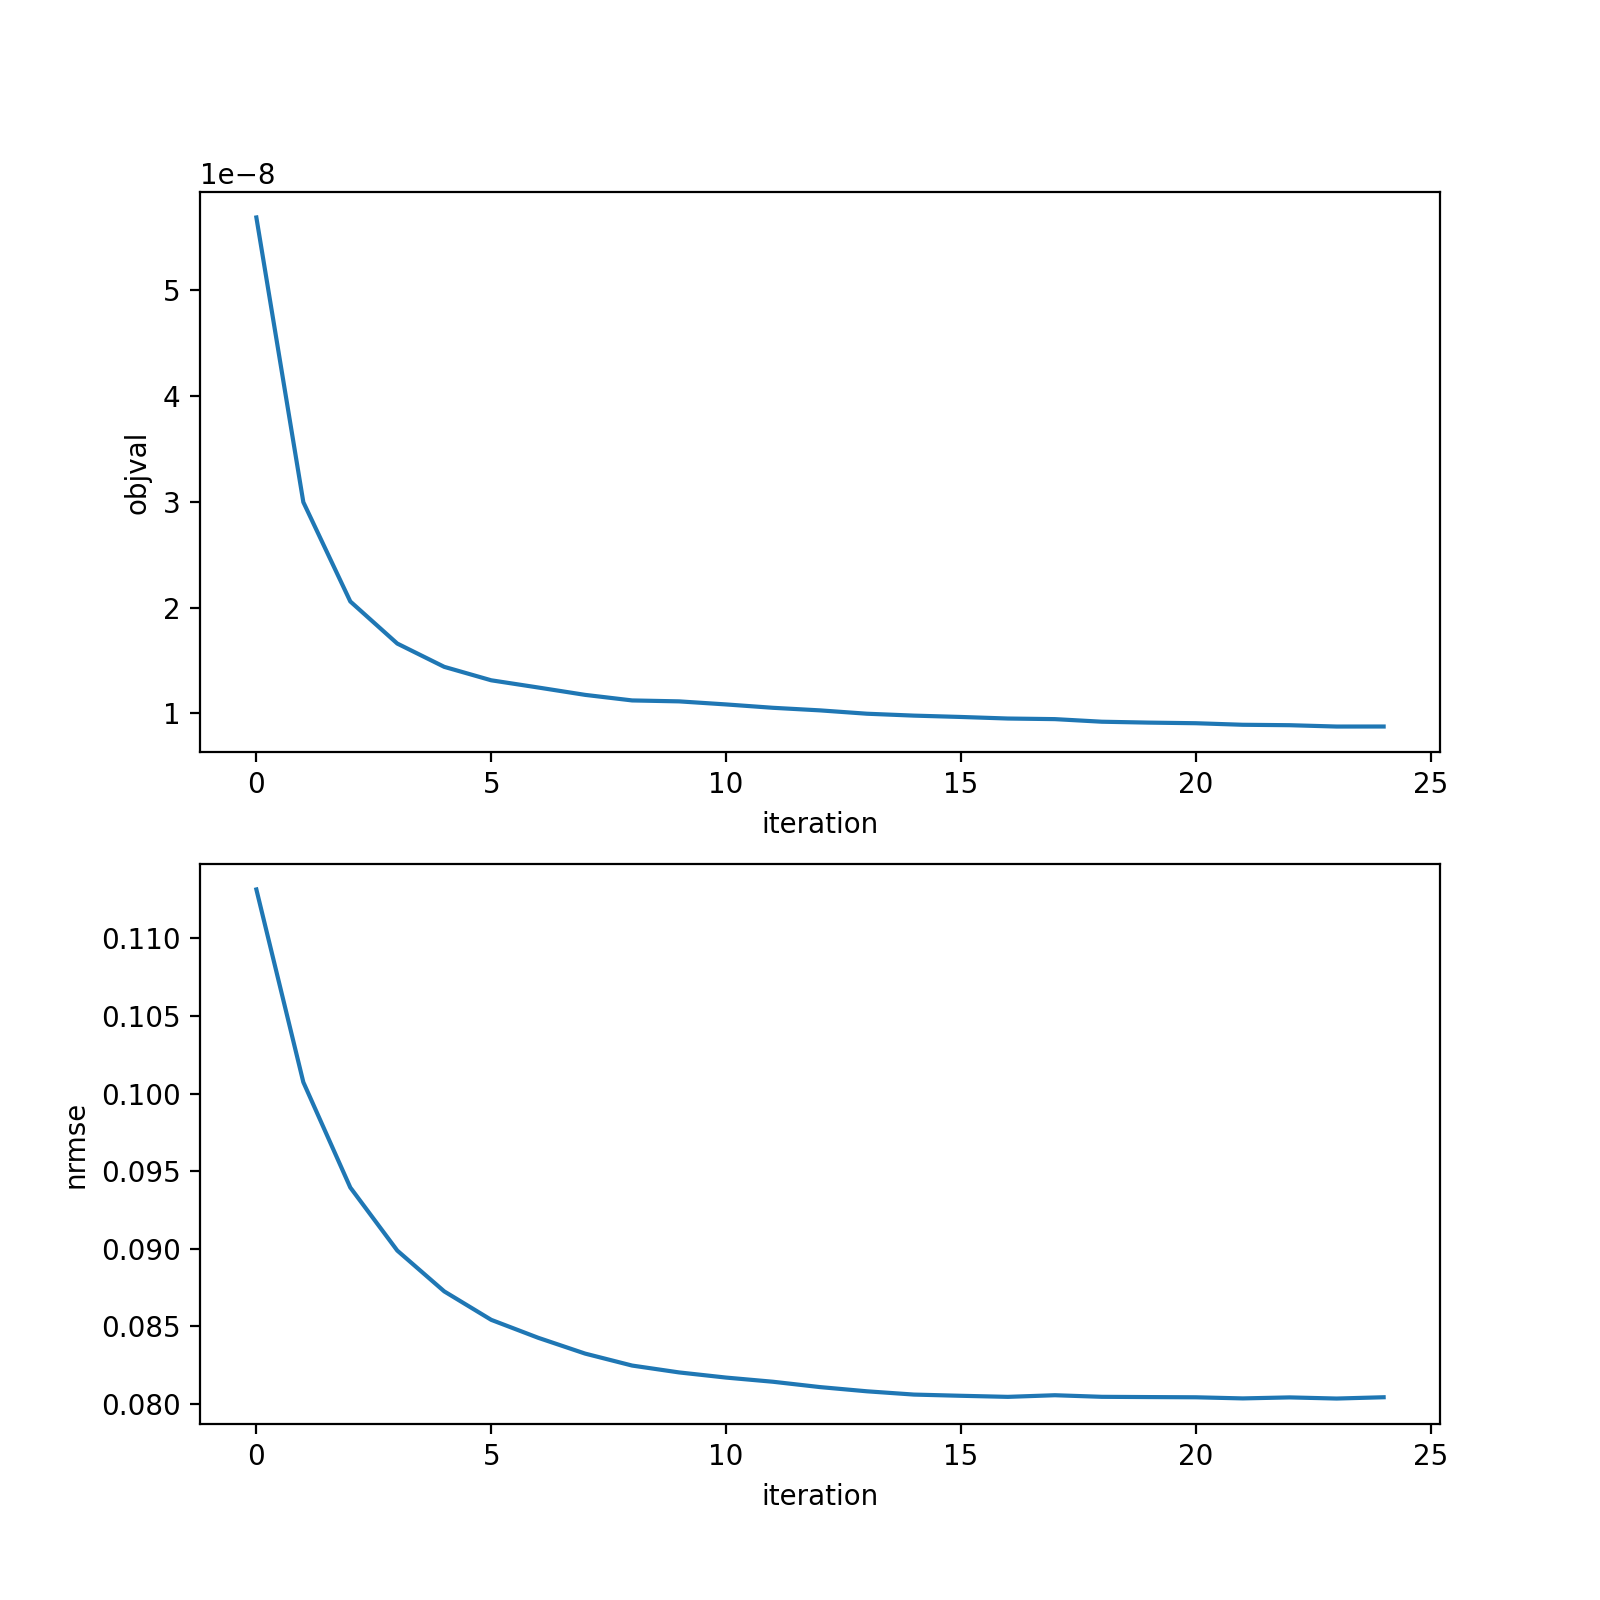

Text(0.5, 0, 'iteration')

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(app.residuals)
plt.ylabel('objval')
plt.xlabel('iteration')
plt.subplot(2, 1, 2)
plt.plot(app.nrmse_vals)
plt.ylabel('nrmse')
plt.xlabel('iteration')

(64, 100) (100, 6241)
[79, 79, 8, 8]
(8, 8, 100) (100, 79, 79)


<IPython.core.display.Javascript object>


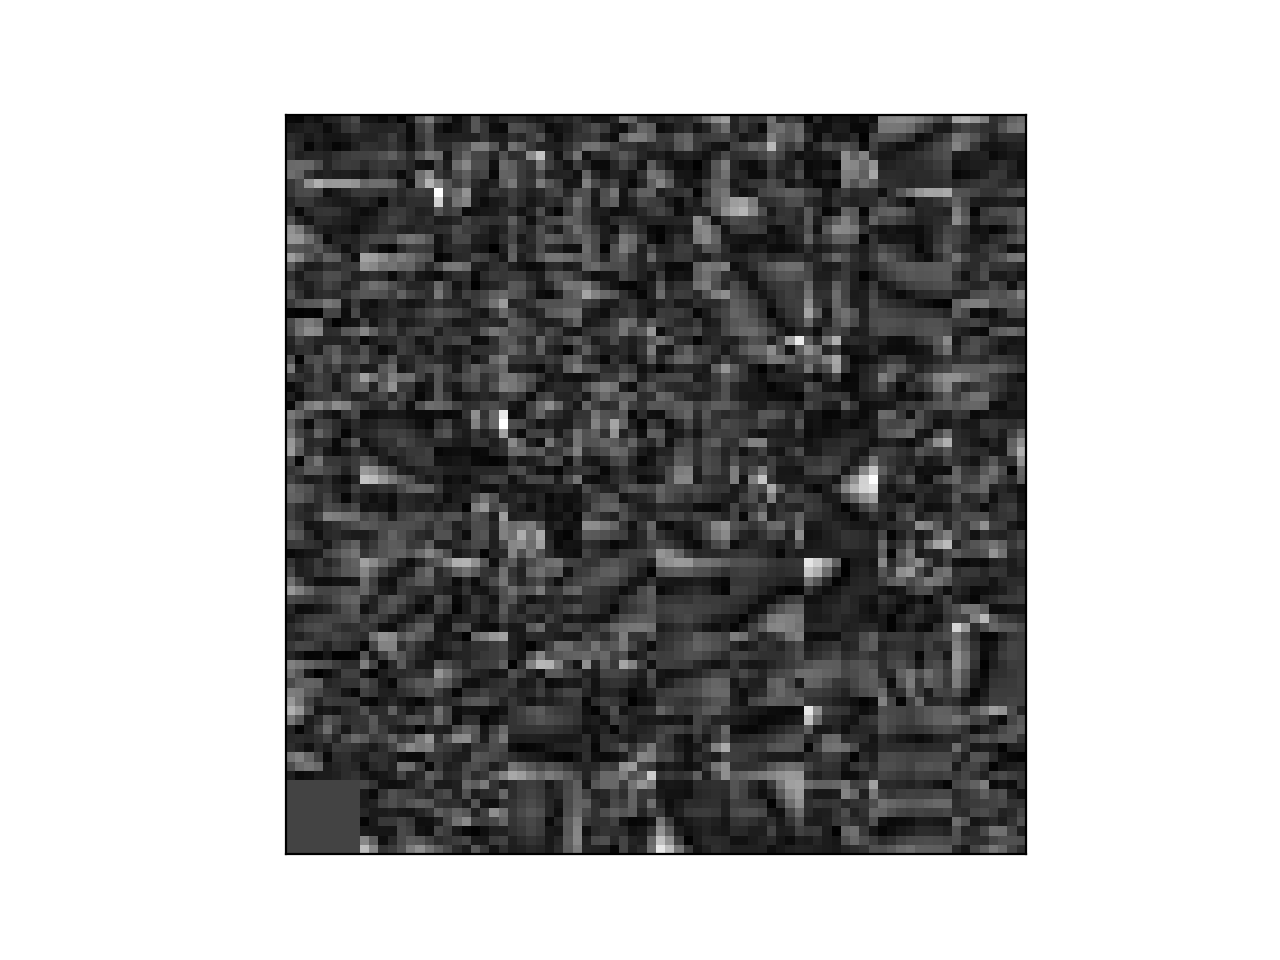

In [53]:
Lhat_flat, Rhat_flat = out[0], out[1]
print(Lhat_flat.shape, Rhat_flat.shape)
print(app.img_blocks_shape)
Lhat = Lhat_flat.reshape((*block_shape, num_filters))
Rhat = Rhat_flat.reshape((num_filters, *app.img_blocks_shape[:2]))

print(Lhat.shape, Rhat.shape)
# out = sp.to_dpevice(out_flat.T.reshape(*img_blocks.shape[:2], -1))


# print(out.shape)
# %matplotlib notebook
# pl.ImagePlot(out, x=0, y=1, z=2)

# interpolation = 'lanczos'
# interpolation = 'bilinear'
interpolation = 'nearest'

pl.ImagePlot(Lhat, x=-3, y=-2, z=-1, interpolation=interpolation)


<IPython.core.display.Javascript object>


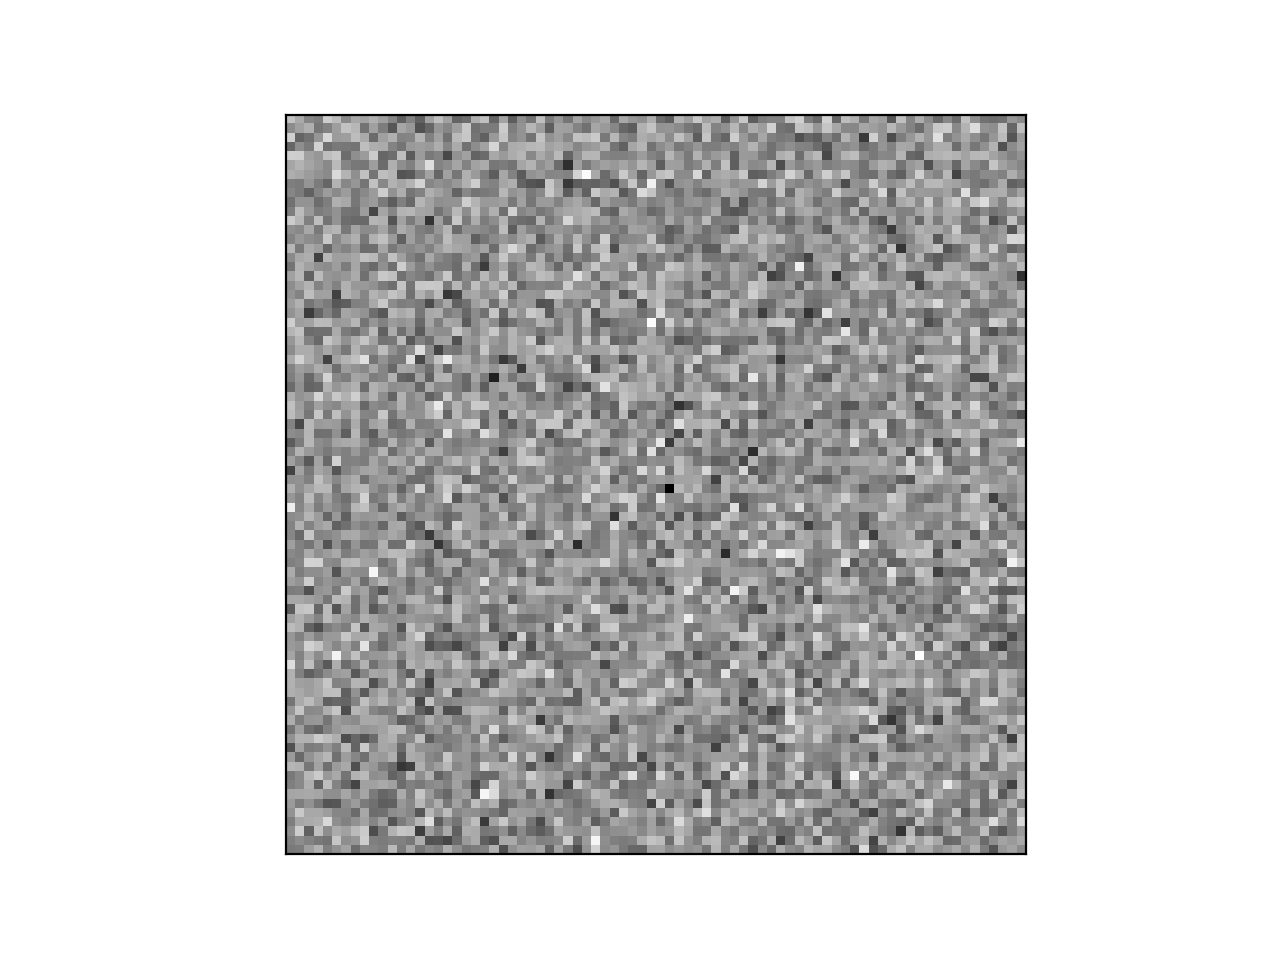

In [62]:
pl.ImagePlot(np.random.randn(*Lhat.shape), x=-3, y=-2, z=-1)

<IPython.core.display.Javascript object>


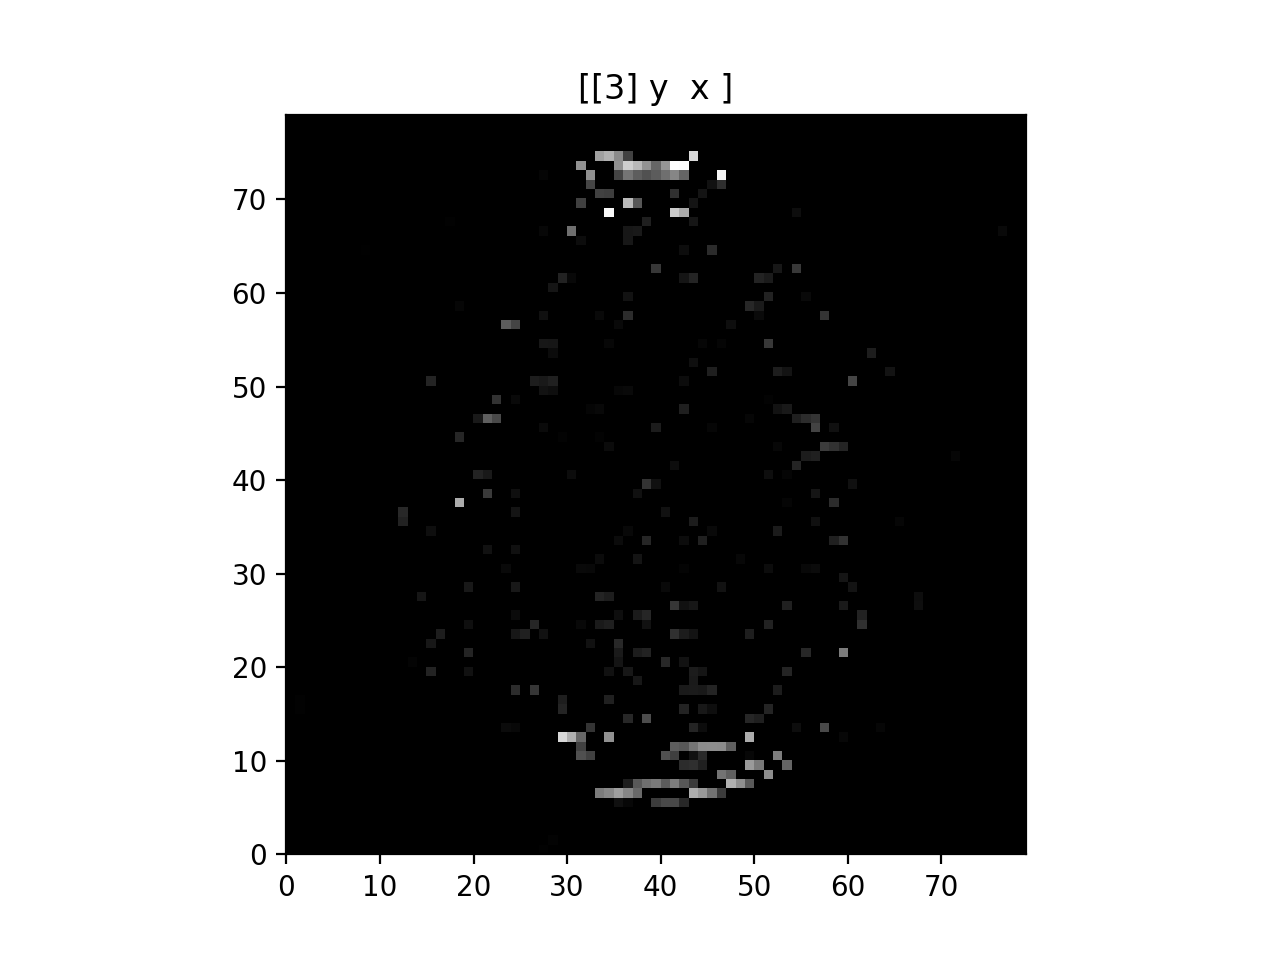

In [70]:
pl.ImagePlot(Rhat[0:,...], z=0)

In [58]:
img_hat_flat = Lhat_flat.dot(Rhat_flat)
img_dict = app.reshape_block_op * img_hat_flat.T
img_dict /= app.block_scale_factor
img_out = app.img_out

device = sp.Device(3)
with device:
    img_linear = sp.app.LinearLeastSquares(app.mri_op,
                                           _ksp,
                                           lamda=.01,
                                          max_iter=30).run()



In [59]:
from bart import bart
img_l1 = bart(1, 'pics -l1 -S -r.00105 -i 100', _ksp, np.ones(_ksp.shape))

<IPython.core.display.Javascript object>


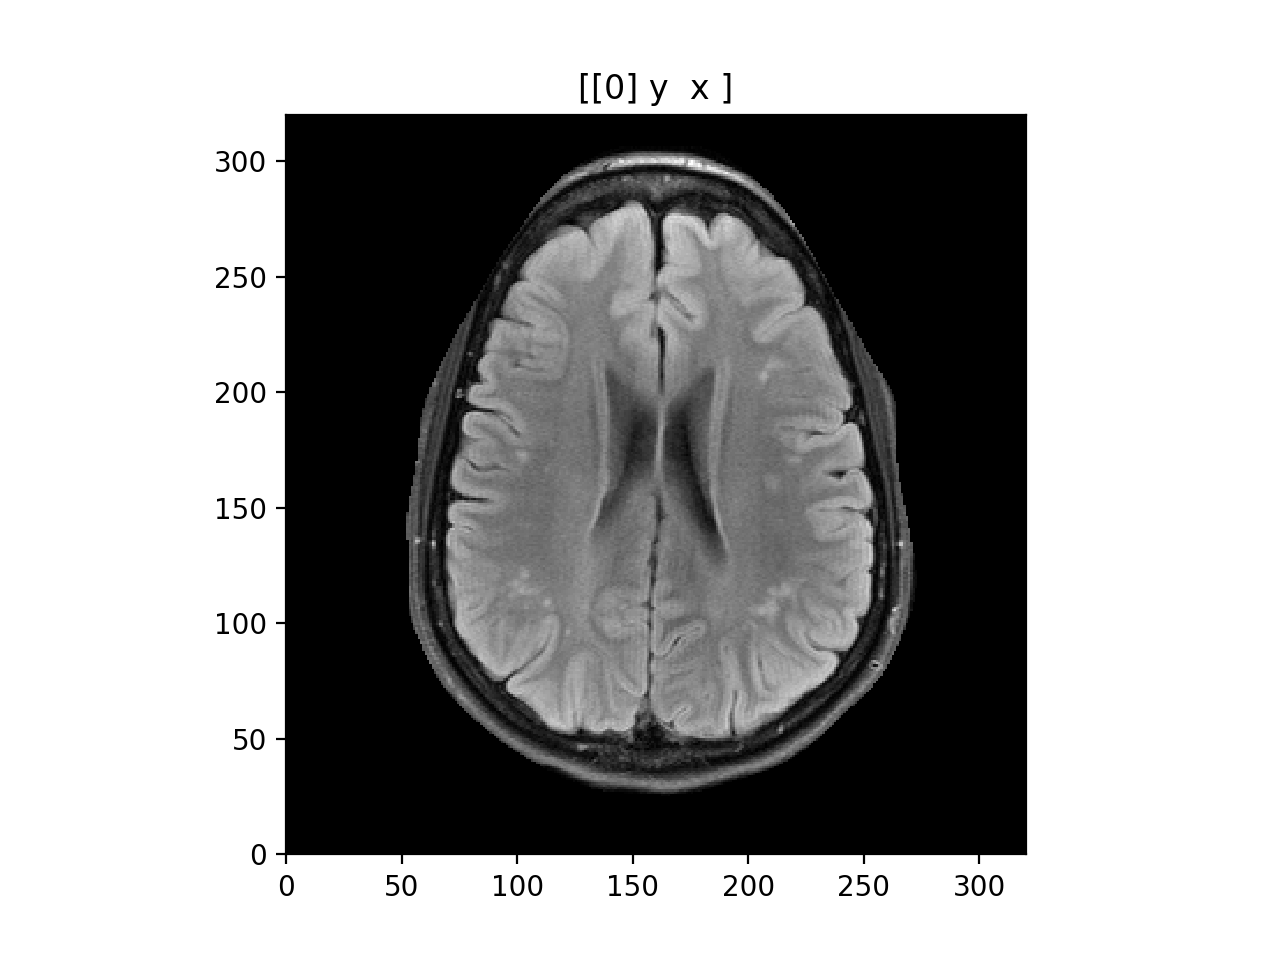

In [60]:
pl.ImagePlot(np.stack((img, img_out, img_dict, img_linear, img_l1)))

In [ ]:
pl.ImagePlot(np.stack((img, img-img_out, img-img_linear)))

In [ ]:
A = app.reshape_block_op
print(A.ishape, A.oshape)
x = np.random.randn(*app.reshape_block_op.ishape)
y = np.random.randn(*app.reshape_block_op.oshape)

AHy = A.H * img
AAHy = A * AHy
AAHy /= app.block_scale_factor

print(AHy.shape)

print(np.linalg.norm(img - AAHy))

# print(np.sum(np.conj(Ax).ravel() * y.ravel()))
# print(np.sum(np.conj(x).ravel() * AHy.ravel()))

pl.ImagePlot(np.stack((img, AAHy, img - AAHy)))


In [ ]:
pl.ImagePlot(AHy.reshape((-1, 8, 8)))